# **Main Notebook for Thesis Project**

## SEC Filings for Trading Strategies: A Quarterly Prediction Model

Welcome to the main notebook of my thesis project. The aim of this project was to investigate the predicive capability of SEC filings, specifically annual `10-K` and quarterly `10-Q` , for trading. The investigation was conducted using a machine learning model trained for quarterly predictions; as a disclaimer, the annual filings were treated as `Q4`. A portfolio of selected stocks was created, and for every filing of each company a trade decision was given using the model's prediction. The purpose of this notebook is to provide a walkthrough of the project.

## Importing Libraries and Classes

To accomplish our goal, we need to utilise many libraries and our created classes. Therefore, let's start by importing them. 

Python libraries:
1. Torch: machine learning framework for our model
2. Requests: library for requesting online data
3. Numpy: library for numerical manipulations and arrays
4. Pandas: library for data storage
5. Matplotlib: library for plotting

Created classes:
1. Stock: class representing stock object
2. EDGAR: class representing SEC data object
3. Portfolio: class representing portfolio object
4. Model: class representing machine learning model

In [1]:
import torch
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# filespace
from stock import Stock
from edgar import EDGAR
from portfolio import Portfolio

plt.style.use('seaborn-v0_8-whitegrid')
print(f"PyTorch Version: {torch.__version__}")

PyTorch Version: 2.3.1


An important part of the project is the sentiment analysis of forward-looking statements `FLS`. Creating an accurate NLP model is challenging task in itself. Therefore, we will utilise `FinBERT` in this project. See: https://huggingface.co/ProsusAI/finbert

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
FinBERT = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

/Users/mehmet/anaconda3/envs/kcl-thesis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Constants and Functions

Second step is initialising constants and creating functions that will help with our goal.
- `AGENT` is used to access SEC EDGAR.
- `TICKERS` is a list for storing the tickers of selected companies
- `device` stores the computing source used for machine learning

In [3]:
# agent
AGENT = {'User-Agent': 'mehmet.ozturk@kcl.ac.uk'}
# stocks
TICKERS = ['AAPL', 'ADBE', 'AMD', 'NVDA', 'TSLA']
# set the device
device = "mps" if torch.backends.mps.is_available() else "cpu"
# setting seed
torch.manual_seed(42)
# dates (usually updated before used)
START_DATE = '2017-01-01'
END_DATE = '2024-01-01'

The function `pct_change` helps with calculating the percentage change for our dataset.

In [4]:
def pct_change(old_value, new_value) -> float:
    """Method for calculating percentage change with absolute denominator.

    old_value: Old value
    new_value: New value
    """
    eps = 1

    difference = new_value - old_value
    
    abs_old_value = abs(old_value) + eps
    
    pct_change = (difference / abs_old_value)
    
    return pct_change

The function `trade_direction` helps with labelling for machine learning. There are three labels that represent trade decisions:
- `0` for buy
- `1` for sell
- `2` for hold

In [5]:
def trade_direction(change: float, threshold: float) -> int:
    """Method for determining and labelling actual trade decision.

    change: Percentage change in price
    threshold: Threshold for comparison
    """
    if change >= threshold:
        return 0
    elif change <= -threshold:
        return 1
    elif threshold > change > -threshold:
        return 2
    else:
        return np.NAN

## Data Collection and Portfolio Creation

One of the most important parts of creating a machine learning model is the data used for training. For this project, we are using both quantitative and qualitative data found in SEC filings of companies. In order to access these filings, first we need to obtain the company's Central Index Key `CIK`, which are stored in a `.json` file: https://www.sec.gov/files/company_tickers.json.

In [6]:
# getting CIK DataFrame
ciks = requests.get(
    'https://www.sec.gov/files/company_tickers.json',
    headers = AGENT
)
# success check
if ciks.status_code == 200:
    print(f'Status: [{ciks.status_code}], CIK data obtained successfully.')
else:
    print(f'Status: [{ciks.status_code}], error otaining CIK.')
    
# transforming into DataFrame
ciks = pd.DataFrame.from_dict(
    ciks.json(),
    orient = 'index'
)
# formatting to string
ciks = ciks.astype(str)
ciks.head()

Status: [200], CIK data obtained successfully.


,cik_str,ticker,title
0,320193,AAPL,Apple Inc.
1,789019,MSFT,MICROSOFT CORP
2,1045810,NVDA,NVIDIA CORP
3,1652044,GOOGL,Alphabet Inc.
4,1018724,AMZN,AMAZON COM INC


Additionally, we initialise the portfolio consisting of our selected stocks. The variable `portfolio` is an object of `Portfolio` class, and it stores the `TICKERS` inside `portfolio.stock_tickers`. Also, download the price history of selected stocks using the `portfolio.get_price_history` function and selected dates.

In [7]:
portfolio = Portfolio(stock_tickers=TICKERS)
portfolio.price_history = portfolio.get_price_history(start_date=START_DATE, end_date=END_DATE)
print(f"Selected stocks' tickers: {portfolio.stock_tickers}")
portfolio.price_history.head()

[*********************100%%**********************]  5 of 5 completed

Selected stocks' tickers: ['AAPL', 'ADBE', 'AMD', 'NVDA', 'TSLA']


Ticker,AAPL,ADBE,AMD,NVDA,TSLA
Date,,,,,
2017-01-03,29.04,103.48,11.43,2.55,14.47
2017-01-04,29.00,104.14,11.43,2.61,15.13
2017-01-05,29.15,105.91,11.24,2.54,15.12
2017-01-06,29.48,108.30,11.32,2.58,15.27
2017-01-09,29.75,108.57,11.49,2.68,15.42


Plotting the prices movement from start to end date.

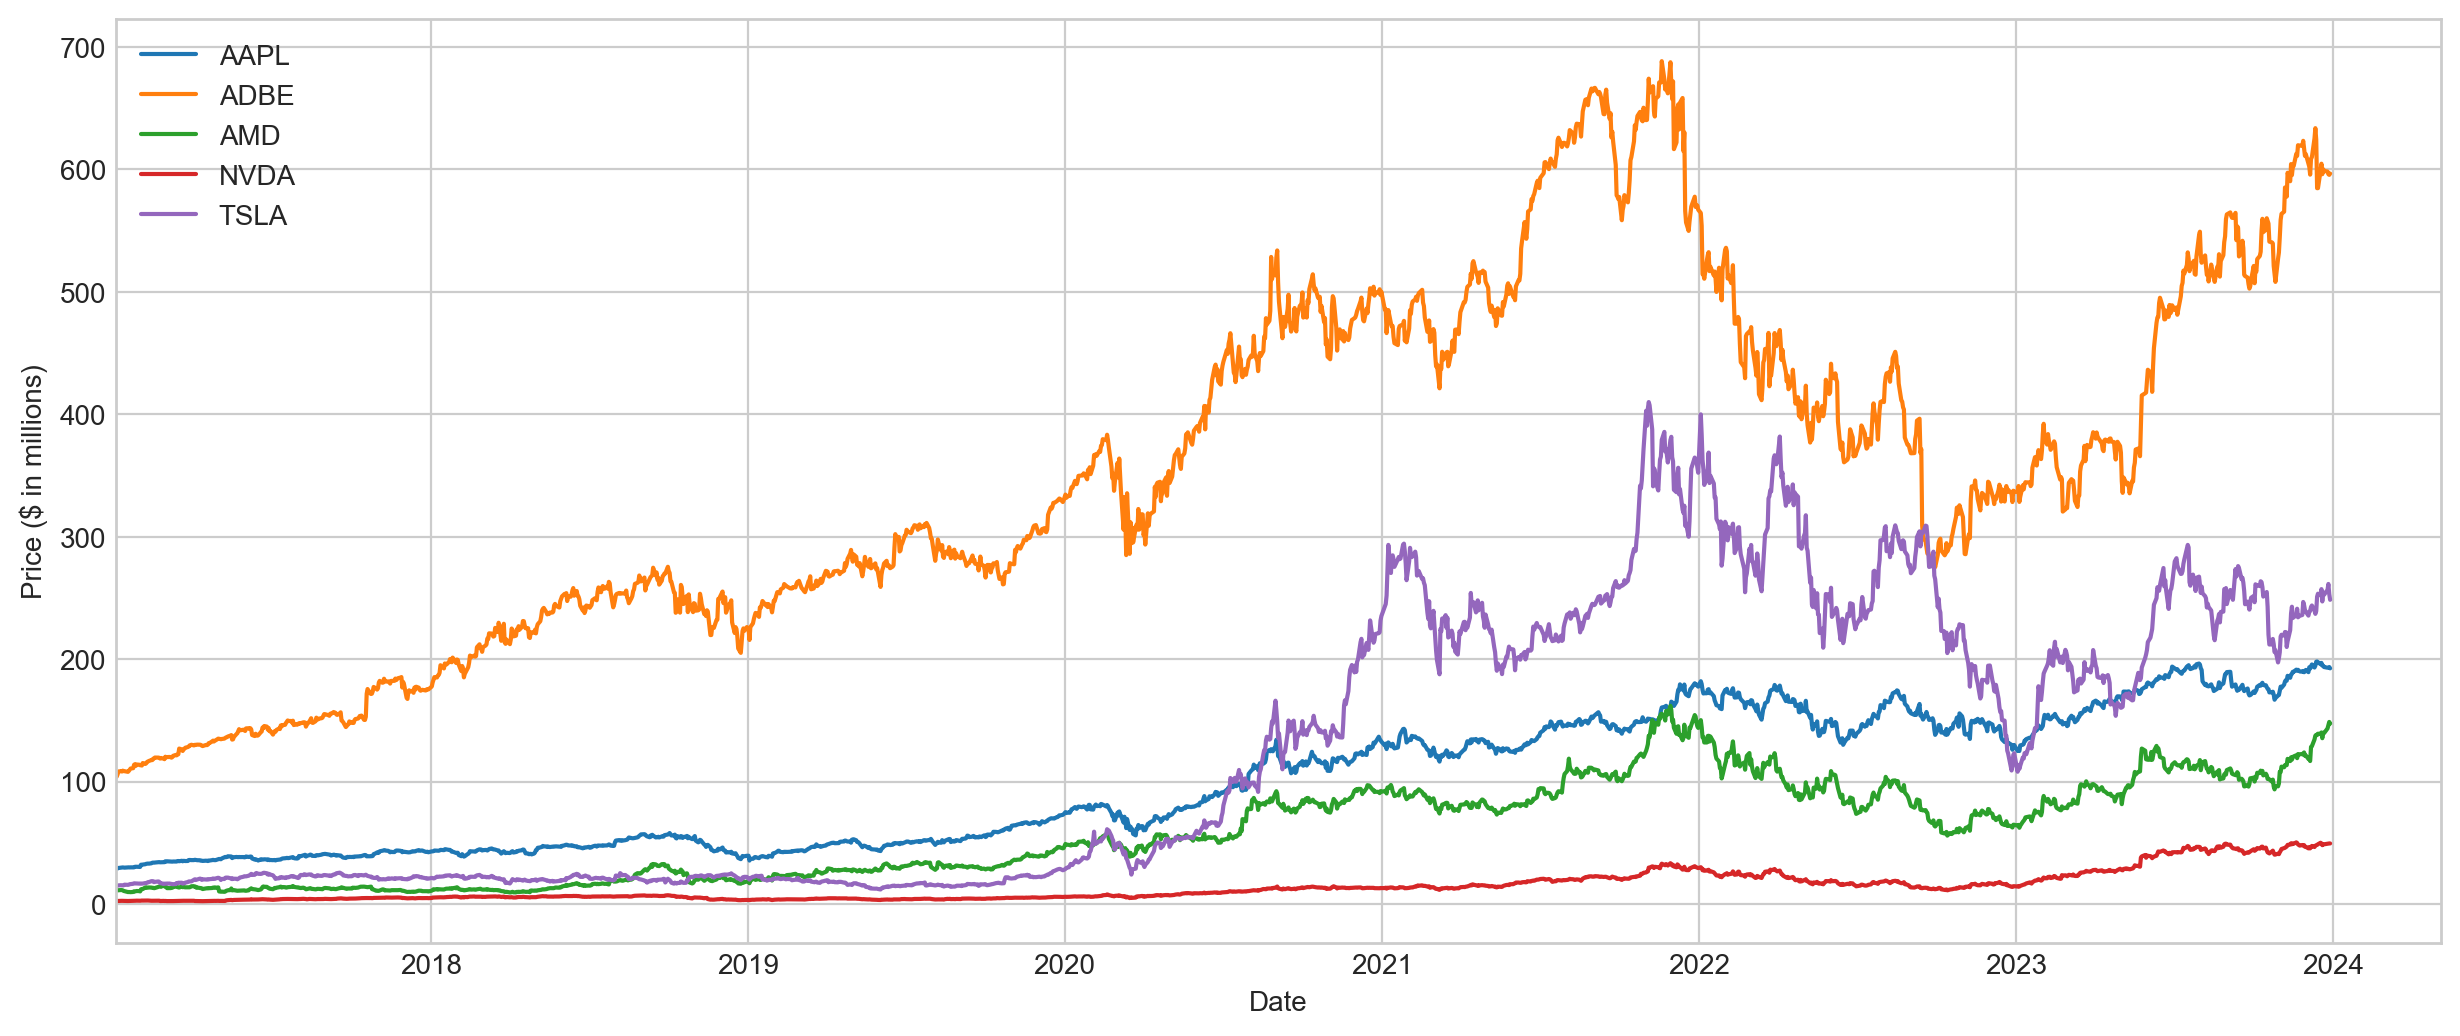

In [8]:
fig, ax = plt.subplots(figsize=(15, 6), dpi=200)

for ticker in portfolio.stock_tickers:
    ax.plot(portfolio.price_history.index, portfolio.price_history[ticker], label=f'{ticker}')

ax.set_xlabel('Date')
ax.set_ylabel('Price ($ in millions)')

ax.set_xlim(left=portfolio.price_history.index.min())

ax.legend()
ax.grid(True)

plt.show()

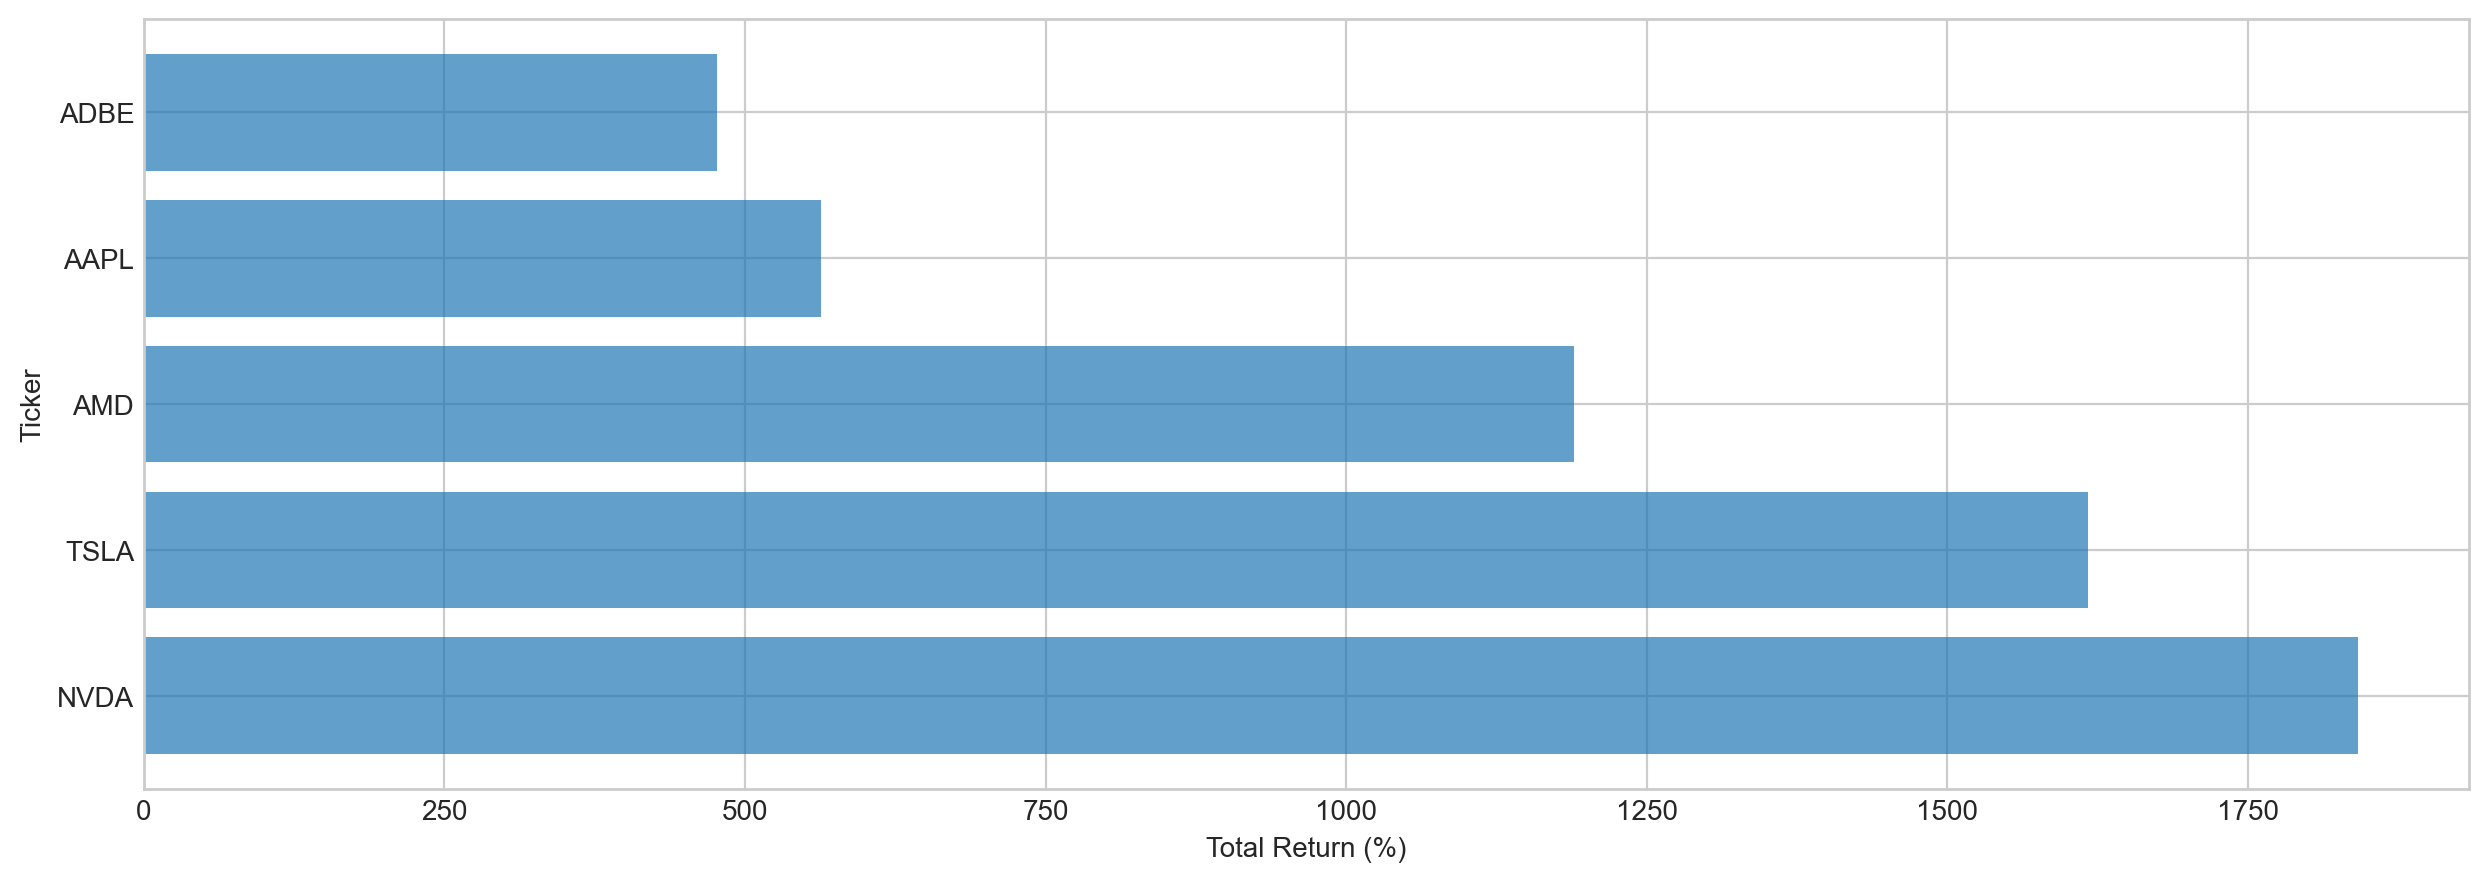

In [9]:
initial_prices = portfolio.price_history.iloc[0]
final_prices = portfolio.price_history.iloc[-1]
returns = (final_prices - initial_prices) / initial_prices * 100

returns_df = pd.DataFrame({
    'Ticker': initial_prices.index,
    'Initial Price': initial_prices.values,
    'Final Price': final_prices.values,
    'Return': returns.values
})

returns_df = returns_df.sort_values(by='Return', ascending=False).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(15, 5), dpi=200)  # Set DPI here

ax.barh(returns_df['Ticker'], returns_df['Return'], alpha=0.7)

ax.set_xlabel('Total Return (%)')
ax.set_ylabel('Ticker')

plt.show()

We can see that the best performing stock in this time period is `NVDA` with approximately 1850% return.

Sometimes we will have to use `pd.Timestamp` objects, so it is important to reset the dates using the dates in the `portfolio.price_history`.

In [10]:
portfolio.date = portfolio.price_history.index[0]
START_DATE = portfolio.date
END_DATE = portfolio.price_history.index[-1]

print(f"Start date: {START_DATE}\nEnd date: {END_DATE}")

Start date: 2017-01-03 00:00:00
End date: 2023-12-29 00:00:00


Now, we setup the equal weight portfolio using $100,000 through `setup_equal_weight()` function. The function `describe` will help us with visualising the portfolio and relevant information. 

In [11]:
portfolio.setup_equal_weight()
portfolio.describe()

Current positions as of 2017-01-03 00:00:00
---------------
Ticker: AAPL
Price: 29.04
Quantity: 688
Weight: 0.1997952
---------------
Ticker: ADBE
Price: 103.48
Quantity: 193
Weight: 0.1997164
---------------
Ticker: AMD
Price: 11.43
Quantity: 1749
Weight: 0.1999107
---------------
Ticker: NVDA
Price: 2.55
Quantity: 7843
Weight: 0.19999650000000002
---------------
Ticker: TSLA
Price: 14.47
Quantity: 1382
Weight: 0.1999754
---------------
Cash: 60.58
---------------
Portfolio worth: 100000.0


With the portfolio setup, it is time to initialise the EDGAR objects inside our stocks to gather information from SEC EDGAR. The `run` function is created to automate the process of obtaining data. `stock.filing_dates` store all the dates of quarterly and annual filings. In the context of the project, the filing date is more important than the report date since the filing date is for public.

In [12]:
for ticker, stock in portfolio.positions.items():
    stock.edgar = EDGAR(ticker=ticker, ciks=ciks)
    stock.edgar.run(start_date=START_DATE, end_date=END_DATE)
    stock.filing_dates = list(stock.edgar.sec_data.keys())

Respone: [200], metadata obtained successfully.
Respone: [200], filing obtained successfully.
Current filename:	 a10-qq1201812302017.htm
Balance Sheet: 4
Multiplier: 1000000
Respone: [200], filing obtained successfully.
Current filename:	 a10-qq220183312018.htm
Balance Sheet: 4
Multiplier: 1000000
Respone: [200], filing obtained successfully.
Current filename:	 a10-qq320186302018.htm
Balance Sheet: 4
Multiplier: 1000000
Respone: [200], filing obtained successfully.
Current filename:	 a10-k20189292018.htm
Balance Sheet: 41
Multiplier: 1000000
Respone: [200], filing obtained successfully.
Current filename:	 a10-qq1201912292018.htm
Balance Sheet: 4
Multiplier: 1000000
Respone: [200], filing obtained successfully.
Current filename:	 a10-qq220193302019.htm
Balance Sheet: 4
Multiplier: 1000000
Respone: [200], filing obtained successfully.
Current filename:	 a10-qq320196292019.htm
Balance Sheet: 4
Multiplier: 1000000
Respone: [200], filing obtained successfully.
Current filename:	 a10-k201992

In [13]:
for ticker, stock in portfolio.positions.items():
    print(f"{ticker}: {len(stock.filing_dates)} {stock.filing_dates}")

AAPL: 24 [Timestamp('2018-02-02 00:00:00'), Timestamp('2018-05-02 00:00:00'), Timestamp('2018-08-01 00:00:00'), Timestamp('2018-11-05 00:00:00'), Timestamp('2019-01-30 00:00:00'), Timestamp('2019-05-01 00:00:00'), Timestamp('2019-07-31 00:00:00'), Timestamp('2019-10-31 00:00:00'), Timestamp('2020-01-29 00:00:00'), Timestamp('2020-05-01 00:00:00'), Timestamp('2020-07-31 00:00:00'), Timestamp('2020-10-30 00:00:00'), Timestamp('2021-01-28 00:00:00'), Timestamp('2021-04-29 00:00:00'), Timestamp('2021-07-28 00:00:00'), Timestamp('2021-10-29 00:00:00'), Timestamp('2022-01-28 00:00:00'), Timestamp('2022-04-29 00:00:00'), Timestamp('2022-07-29 00:00:00'), Timestamp('2022-10-28 00:00:00'), Timestamp('2023-02-03 00:00:00'), Timestamp('2023-05-05 00:00:00'), Timestamp('2023-08-04 00:00:00'), Timestamp('2023-11-03 00:00:00')]
ADBE: 23 [Timestamp('2018-03-28 00:00:00'), Timestamp('2018-06-27 00:00:00'), Timestamp('2018-09-26 00:00:00'), Timestamp('2019-01-25 00:00:00'), Timestamp('2019-03-27 00:00:

Plotting quarterly returns, which are returns from one filing to other.

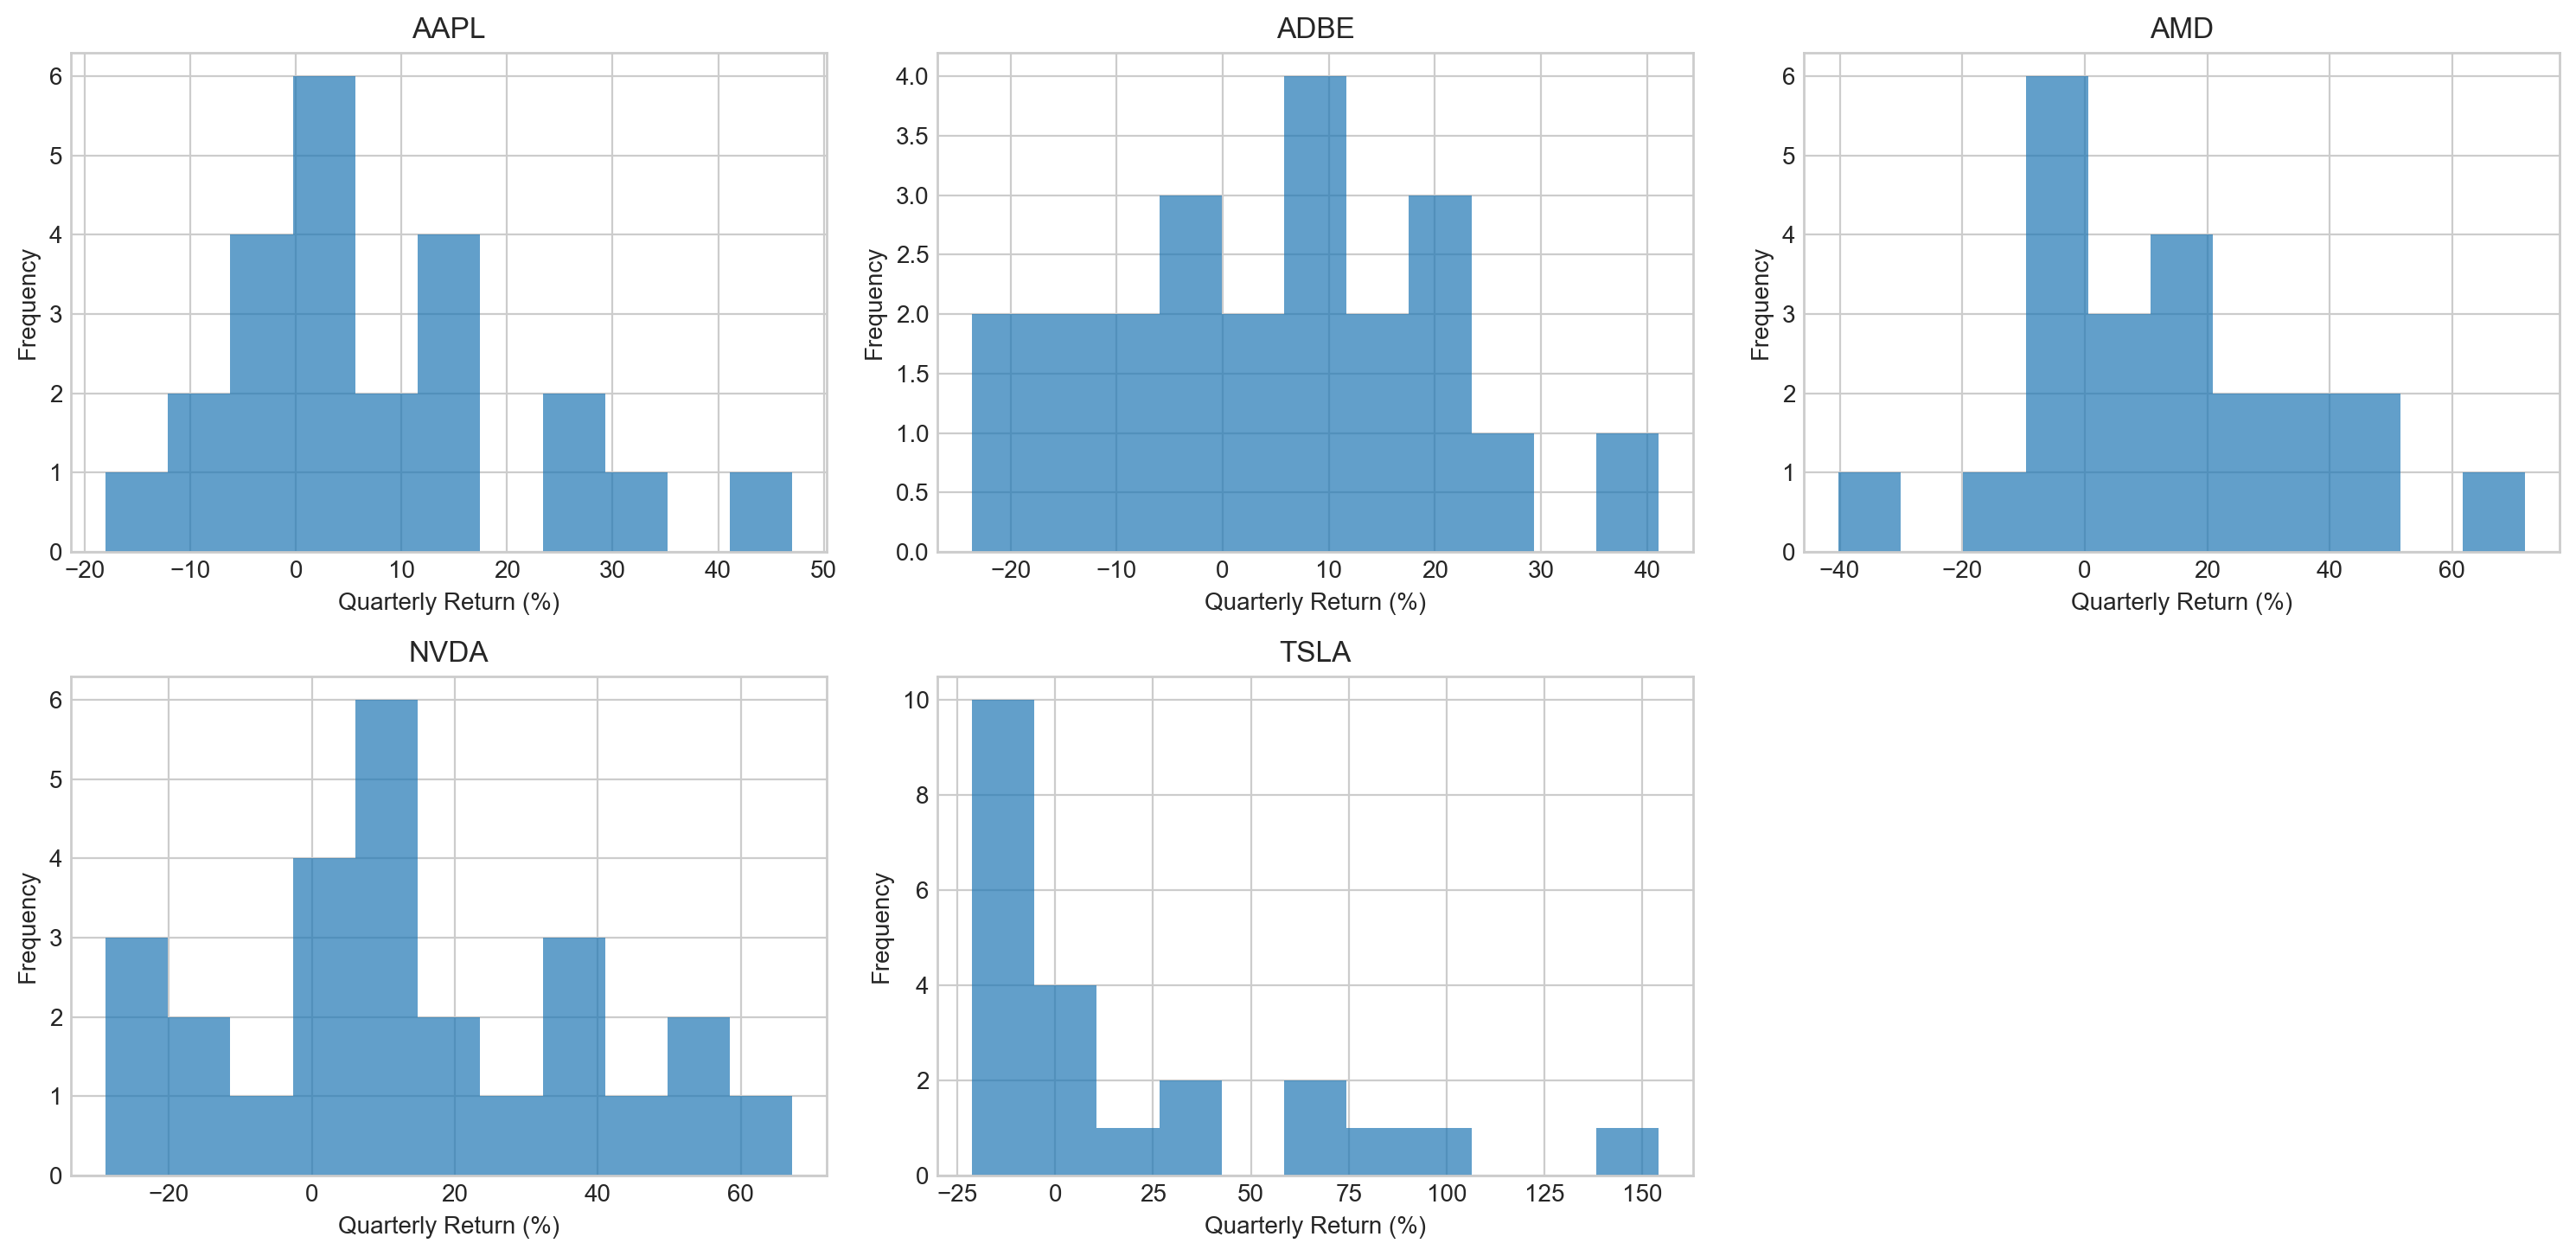

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8), dpi=200) 

axes = axes.flatten()

for i, ticker in enumerate(portfolio.price_history.columns):
    dates = list(portfolio.positions[ticker].edgar.sec_data.keys())
    temp = portfolio.price_history.loc[dates][ticker]
    temp = temp.pct_change() * 100
    temp.hist(bins=11, ax=axes[i], alpha=0.7)
    axes[i].set_title(ticker)
    axes[i].set_ylabel('Frequency')
    axes[i].set_xlabel('Quarterly Return (%)')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

`TSLA` and `AMD` are the most volatile stocks.

## Creating Dataset

At this point all the data has been collected, and it is time to create the dataset. The dataset will consist of the following features:
1. Cash
2. Current assets
3. Current liabilities
4. Shareholder equity
5. Revenue
6. Gross profit
7. Operating income
8. Net income
9. Earnings per share (EPS)
10. Net cash operating
11. Net cash investing
12. Net cash financing
13. Sentiment
14. Trade

`FinBERT` takes the textual statements for input and outputs the appropriate score (in decimal points) for each sentiment: positive, negative, neutral summing upto 1. For each filing, the output of each statement is summed up. The sentiment for that filing is calculated through the equation 

$$\frac{positive - negative}{positive + negative}$$

using scores.

In [15]:
dataset = pd.DataFrame()

for ticker, stock in portfolio.positions.items():
    temp = pd.DataFrame.from_dict(stock.edgar.sec_data, orient='index')
    temp = temp.reindex(sorted(temp.columns), axis=1)

    # getting all dates
    dates = list(temp.index)

    # adding prices
    temp['price'] = portfolio.price_history.loc[dates][ticker]

    # FinBERT for quantifying FLS
    qualitative = {}
    for date in dates:
        qualitative[date] = {}
        positive_score = 0
        negative_score = 0
        # neutral_score = 0

        filing = temp.loc[date]['statements']

        for statement in filing:
            # FinBERT's own tokenizer
            inputs = tokenizer(text=statement, return_tensors='pt', max_length=512, truncation=True, padding=True)

            with torch.no_grad():
                outputs = FinBERT(**inputs)

            predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

            positive_score += predictions[0][0].item()
            negative_score += predictions[0][1].item()
            # neutral_score += predictions[0][2].item()

        # normalising scores
        qualitative[date]['sentiment'] = (positive_score - negative_score) / (positive_score + negative_score)
    
    # dropping statements columns
    temp = temp.drop(columns=['statements'])
    # percentage change for standardising all values in DataFrame
    temp = temp.shift().combine(temp, pct_change)
    # temp = temp.pct_change()
    # concating back quantified qualitative data
    temp = pd.concat([temp, pd.DataFrame.from_dict(qualitative, orient='index')], axis=1).dropna()

    # for creating output labels
    temp_prices = temp['price'].shift(-1)
    # dropping price column
    temp = temp.drop(columns=['price'])
    # creating labels ([0] for buy, [1] for sell and [2] for hold)
    temp['trade'] = temp_prices.apply(lambda change: trade_direction(change=change, threshold=0.03))

    dataset = pd.concat([dataset, temp], axis=0).dropna()

dataset = dataset.sort_index()
# print(f"Dataset shape: {dataset.shape}")

In [16]:
dataset

,cash,current assets,current liabilities,eps,gross profit,net cash financing,net cash investing,net cash operating,net income,operating income,revenue,shareholder equity,sentiment,trade
2017-08-23,-0.000503,-0.005668,0.049847,0.064516,0.132174,-0.190652,-0.652520,1.500000,0.149901,0.241877,0.151265,-0.025930,0.835315,0.0
2017-11-21,0.409457,0.050682,-0.004845,0.207071,0.205069,0.350207,0.091603,0.641135,0.437393,0.300872,0.182063,0.063452,0.837642,0.0
2018-02-28,0.428266,0.091520,0.122687,0.196653,0.147865,0.786963,-1.083916,0.173725,0.335322,0.198883,0.104325,0.176165,-0.023993,2.0
2018-05-02,0.639046,-0.095661,-0.228590,-0.237805,-0.309330,-2.502466,3.112583,-0.465239,-0.311139,-0.395067,-0.307567,-0.095015,0.028468,0.0
2018-05-22,-0.808846,0.020854,-0.040763,0.066434,0.148251,-7.440298,-146.958327,0.064065,0.111707,0.206897,0.101683,0.032927,0.912058,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-28,0.339882,0.111724,0.078257,0.029570,0.038414,0.463754,1.064103,0.263438,0.038492,0.023960,0.034586,0.044488,-0.076355,0.0
2023-07-24,-0.046859,0.020420,0.005686,0.027778,0.004877,-0.407725,-0.422705,0.219658,0.029539,-0.099474,0.068498,0.064011,0.666909,1.0
2023-08-02,0.004183,0.054094,0.151285,0.100917,0.035608,1.289575,0.645918,-0.220165,1.194245,0.862069,0.001121,0.008081,0.665214,2.0
2023-08-04,0.150727,0.086314,0.040708,-0.102767,-0.132528,0.065153,-0.811557,-0.076331,-0.177111,-0.187866,-0.137490,-0.030310,-0.932786,2.0


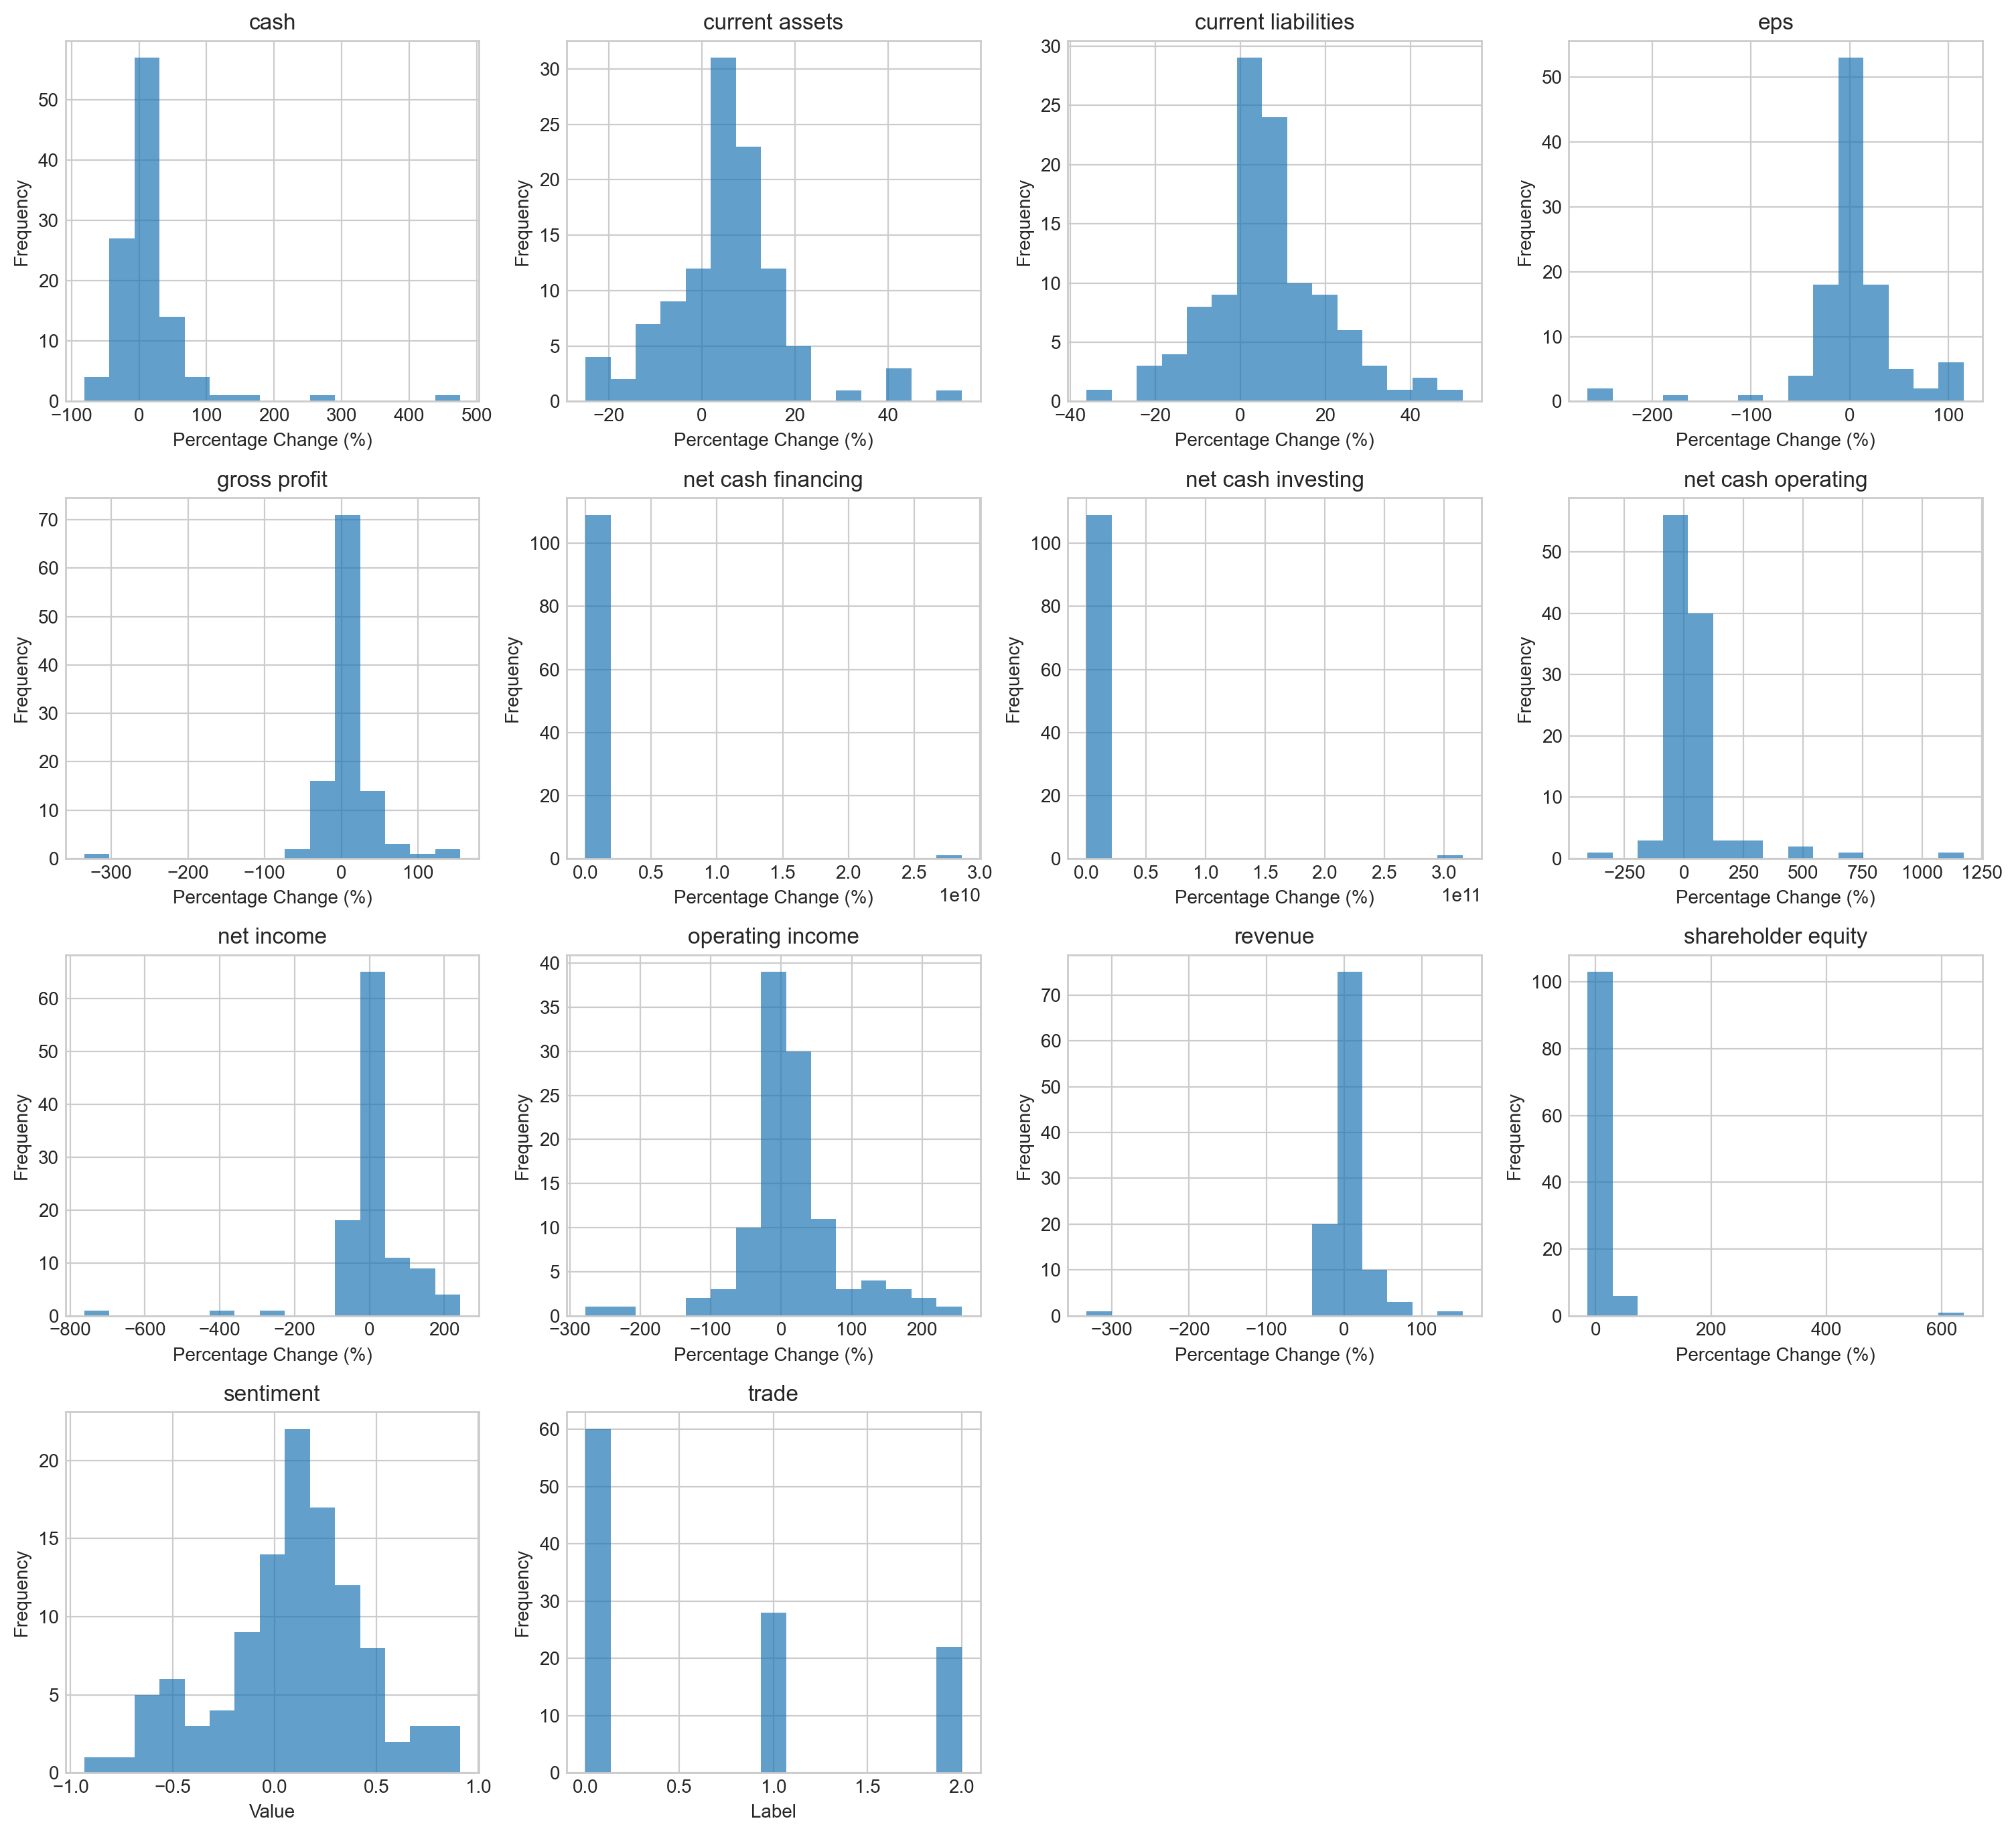

In [17]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15), dpi=200)  # Set DPI here

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each feature in a separate subplot
for i, column in enumerate(dataset.columns):
    if 'sentiment' == column:
        dataset[column].hist(bins=15, ax=axes[i], alpha=0.7) # , color='skyblue', edgecolor='black
        axes[i].set_title(column)
        axes[i].set_ylabel('Frequency')
        axes[i].set_xlabel('Value')
    elif 'trade' == column:
        dataset[column].hist(bins=15, ax=axes[i], alpha=0.7) # , color='skyblue', edgecolor='black
        axes[i].set_title(column)
        axes[i].set_ylabel('Frequency')
        axes[i].set_xlabel('Label')
    else:
        (dataset[column] * 100).hist(bins=15, ax=axes[i], alpha=0.7) # , color='skyblue', edgecolor='black
        axes[i].set_title(column)
        axes[i].set_ylabel('Frequency')
        axes[i].set_xlabel('Percentage Change (%)')

# Remove any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In the historam plot above we can see the distribution of each feature in our dataset. In the `trade` plot, which represents trade decisions, we can see that the dataset is biased towards buy positions. Additionally, especially with `net cash financing` and `net cash investing`, there are extreme edge cases. Most of it is accountable, but these two columns it would be wiser to drop them. Rest of the feautres have similar distributions.

## Training and Testing

### Preparation and Split

Since we have our dataset, it is time to split the data for training and testing. First, split the columns for training and testing.

In [18]:
X_columns = dataset.columns[:-1].difference(['net cash financing', 'net cash investing'])
y_column = dataset.columns[-1]

X_columns, y_column

(Index(['cash', 'current assets', 'current liabilities', 'eps', 'gross profit',
        'net cash operating', 'net income', 'operating income', 'revenue',
        'sentiment', 'shareholder equity'],
       dtype='object'),
 'trade')

In [19]:
X = dataset[X_columns]
y = dataset[y_column]

X.dtypes, y.dtypes

(cash                   float64
 current assets         float64
 current liabilities    float64
 eps                    float64
 gross profit           float64
 net cash operating     float64
 net income             float64
 operating income       float64
 revenue                float64
 sentiment              float64
 shareholder equity     float64
 dtype: object,
 dtype('float64'))

We can see that in our dataset with 110 filings, 60 of them shoud be a buy, 28 of them should be a sell, and 22 of them should be hold.

In [20]:
y.value_counts()

trade
0.0    60
1.0    28
2.0    22
Name: count, dtype: int64

### Creating Tensors

The PyTorch framework requires data to be transformed into tensors.

In [21]:
X = torch.from_numpy(X.values).type(torch.float).to(device=device)
y = torch.from_numpy(y.values).type(torch.long).to(device=device)

The data from 2017 until 2022 will be used for training, and the data from 2022 to 2024 will be used testing the model.

In [22]:
timestamps = dataset.index
timestamp = timestamps[timestamps.year == 2022].min()
split_idx = dataset.index.get_loc(timestamp)

timestamp, split_idx, split_idx / len(dataset)

(Timestamp('2022-01-21 00:00:00'), 75, 0.6818181818181818)

Approximately, 70% of the data will be used for training.

In [23]:
X_train = X[:split_idx]
X_test = X[split_idx:]

y_train = y[:split_idx]
y_test = y[split_idx:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([75, 11]),
 torch.Size([75]),
 torch.Size([35, 11]),
 torch.Size([35]))

### Training the Model

Its time to create our model that will make quarterly predictions. Essentially, we have three categories for prediction which is `multi-classification` task. The chosen machine learning model is `Feed-forward Neural Network`, suitable preference for our task. The model will consist of 4 hidden layers, with a dropout following the first 3 layers. `Dropout` essentially disables some of the features to see their effect on the predictions. The chosen activation function for each layer is `ReLU`. At the end a `softmax` function is used to calculate the scores for each category.

In [24]:
from torch import nn

class Model(nn.Module):
    """
    Class for the machine learning model. 
    """
    def __init__(self, input_size, num_classes) -> None:
        super().__init__()
        self.layer_1 = nn.Linear(input_size, 128)
        self.layer_2 = nn.Linear(128, 64)
        self.layer_3 = nn.Linear(64, 32)
        self.layer_4 = nn.Linear(32, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.dropout(x)
        x = self.relu(self.layer_2(x))
        x = self.dropout(x)
        x = self.relu(self.layer_3(x))
        x = self.dropout(x)
        x = self.layer_4(x)
        return self.softmax(x)

Since there is almost double the amount of `0` (buy) labels than `1` (sell) and `2` (hold), those classes will have higher weight while training. However, the weight should not be too high as well since then it will reverse the bias.

In [25]:
# number of features
input_size = 11
# number of labels
num_classes = 3
# initialising model
model = Model(input_size=input_size, num_classes=num_classes).to(device=device)
# loss function
class_weights = torch.tensor([1.0, 1.5, 1.5])
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights).to(device=device)
# optimiser
optimiser = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

The model will train for 30,000 epochs.

In [26]:
# training rounds
num_epochs = 30000
# training loop
for epoch in range(num_epochs):
    model.train()
    # forward pass
    outputs = model(X_train)
    # calculate loss
    loss = loss_fn(outputs, y_train)
    # zero grad
    optimiser.zero_grad()
    # loss backward
    loss.backward()
    # step the optimiser
    optimiser.step()

    if (epoch % 100) == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [0/30000], Loss: 1.1023
Epoch [100/30000], Loss: 1.0854
Epoch [200/30000], Loss: 1.0493
Epoch [300/30000], Loss: 1.0378
Epoch [400/30000], Loss: 1.0151
Epoch [500/30000], Loss: 1.0126
Epoch [600/30000], Loss: 0.9833
Epoch [700/30000], Loss: 0.9768
Epoch [800/30000], Loss: 0.9794
Epoch [900/30000], Loss: 0.9659
Epoch [1000/30000], Loss: 0.9435
Epoch [1100/30000], Loss: 0.9531
Epoch [1200/30000], Loss: 0.9162
Epoch [1300/30000], Loss: 0.9021
Epoch [1400/30000], Loss: 0.8965
Epoch [1500/30000], Loss: 0.8972
Epoch [1600/30000], Loss: 0.8913
Epoch [1700/30000], Loss: 0.8548
Epoch [1800/30000], Loss: 0.8589
Epoch [1900/30000], Loss: 0.8016
Epoch [2000/30000], Loss: 0.7999
Epoch [2100/30000], Loss: 0.8120
Epoch [2200/30000], Loss: 0.8267
Epoch [2300/30000], Loss: 0.7704
Epoch [2400/30000], Loss: 0.7909
Epoch [2500/30000], Loss: 0.7756
Epoch [2600/30000], Loss: 0.7514
Epoch [2700/30000], Loss: 0.7776
Epoch [2800/30000], Loss: 0.7659
Epoch [2900/30000], Loss: 0.7441
Epoch [3000/30000], Lo

### Evaluating the Model

Now the model has trained for 30,000 epochs using the training data, it is time to test its accuracy on the test data.

In [58]:
model.eval()

correct = 0
total = 0

with torch.inference_mode():
    test_outputs = model(X_test)
    # highest percentage class
    _, predicted_class = torch.max(test_outputs.data, 1)

    # printing prediction and target
    for i in range(X_test.size(0)):
        print(f"Prediction: {predicted_class[i].item()}\tTarget: {y_test[i].item()}")
        print("-" * 30)

    total = y_test.size(0)
    correct += (predicted_class == y_test).sum().item()

accuracy = (correct / total) * 100  
print(f"Accuracy: {accuracy:.2f}%")

Prediction: 0	Target: 1
------------------------------
Prediction: 0	Target: 1
------------------------------
Prediction: 0	Target: 1
------------------------------
Prediction: 0	Target: 0
------------------------------
Prediction: 0	Target: 1
------------------------------
Prediction: 1	Target: 1
------------------------------
Prediction: 1	Target: 1
------------------------------
Prediction: 2	Target: 0
------------------------------
Prediction: 0	Target: 2
------------------------------
Prediction: 0	Target: 1
------------------------------
Prediction: 2	Target: 1
------------------------------
Prediction: 0	Target: 1
------------------------------
Prediction: 0	Target: 1
------------------------------
Prediction: 0	Target: 1
------------------------------
Prediction: 2	Target: 2
------------------------------
Prediction: 0	Target: 0
------------------------------
Prediction: 0	Target: 1
------------------------------
Prediction: 0	Target: 2
------------------------------
Prediction

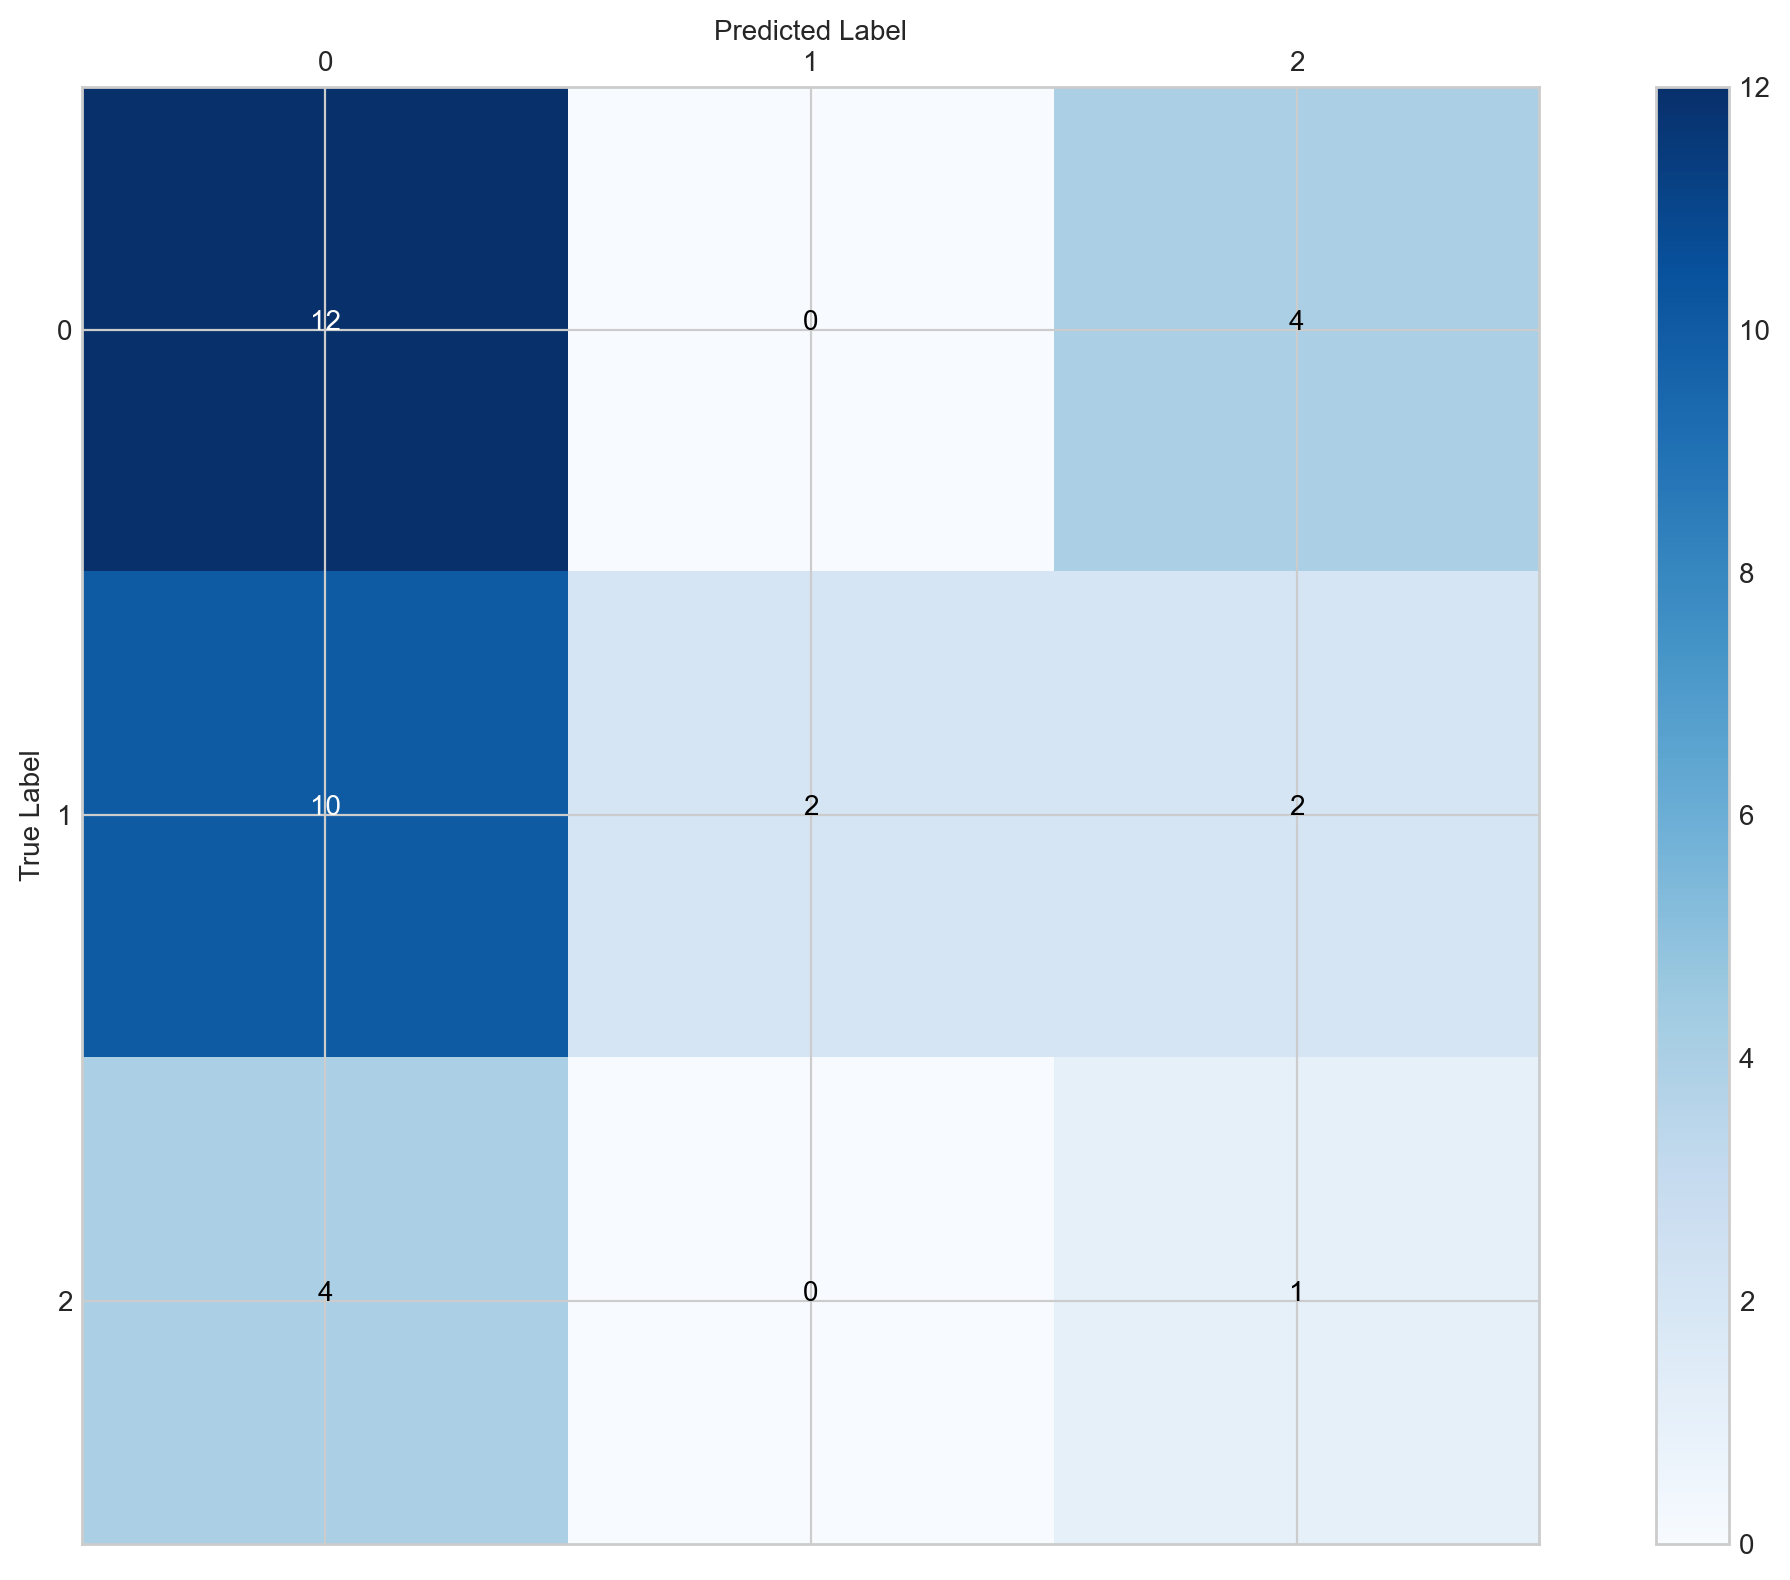

In [72]:
from sklearn.metrics import confusion_matrix

num_classes = 3
conf_matrix = confusion_matrix(y_test.to('cpu').numpy(), predicted_class.to('cpu').numpy(), labels=np.arange(num_classes))

fig, ax = plt.subplots(figsize=(12, 8), dpi = 200)
cax = ax.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)

# Place x-axis tick labels at the top
ax.xaxis.set_label_position('top') 
ax.xaxis.tick_top()

# Create a colorbar
fig.colorbar(cax)

# Tick marks and labels
tick_marks = np.arange(num_classes)
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(tick_marks)
ax.set_yticklabels(tick_marks)

# Labels
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

# Annotate each cell with the count
thresh = conf_matrix.max() / 2.0
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(j, i, format(conf_matrix[i, j], 'd'),
                horizontalalignment="center",
                color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

## Portfolio Comparison

Test dates.

In [28]:
TEST_START_DATE = timestamp.strftime('%Y-%m-%d')
TEST_END_DATE = END_DATE.strftime('%Y-%m-%d')

print(f"Start date: {TEST_START_DATE}\nEnd date: {TEST_END_DATE}")

Start date: 2022-01-21
End date: 2023-12-29


### Equal Weight Portfolio with Trading

In [29]:
portfolio_model = Portfolio(stock_tickers=TICKERS)
portfolio_model.price_history = portfolio_model.get_price_history(TEST_START_DATE, TEST_END_DATE)
portfolio_model.date = portfolio_model.price_history.index[0]
portfolio_model.setup_equal_weight()
portfolio_model.describe()

[*********************100%%**********************]  5 of 5 completed

Current positions as of 2022-01-21 00:00:00
---------------
Ticker: AAPL
Price: 162.41
Quantity: 123
Weight: 0.1997643
---------------
Ticker: ADBE
Price: 499.91
Quantity: 40
Weight: 0.199964
---------------
Ticker: AMD
Price: 118.81
Quantity: 168
Weight: 0.19960080000000002
---------------
Ticker: NVDA
Price: 23.37
Quantity: 855
Weight: 0.19981349999999998
---------------
Ticker: TSLA
Price: 314.63
Quantity: 63
Weight: 0.19821689999999997
---------------
Cash: 264.05
---------------
Portfolio worth: 100000.0


In [30]:
trading_dates = {}
for ticker, stock in portfolio.positions.items():
    dates = []
    for date in stock.filing_dates:
        if pd.to_datetime(TEST_START_DATE) < date:
            dates.append(date)
            # print(f"{ticker}: {date}")
            # print(f"{ticker}: {len(stock.filing_dates)} {stock.filing_dates}")
    trading_dates[ticker] = dates[:-1]

In [52]:
for sim_idx in range(1, len(portfolio_model.price_history)):
    portfolio_model.date = portfolio_model.price_history.index[sim_idx]
    portfolio_model.update_prices()

    for stock in list(portfolio_model.positions.keys()):
        if portfolio_model.date in trading_dates[stock]:
            model_input = torch.from_numpy(dataset.loc[portfolio_model.date][X_columns].values).type(torch.float).to(device=device)
            model_input = model_input.unsqueeze(1).T
            with torch.inference_mode():
                output = model(model_input)
                _, predicted_class = torch.max(output.data, 1)
            
            if predicted_class.item() == 0:
                portfolio_model.buy_stock(portfolio_model.positions[stock])
            elif predicted_class.item() == 1:
                portfolio_model.sell_stock(portfolio_model.positions[stock])
            else:
                continue
    
    if sim_idx == (len(portfolio_model.price_history) - 1):
        portfolio_model.describe()


Current positions as of 2023-12-28 00:00:00
---------------
Ticker: AAPL
Price: 193.58
Quantity: 124
Weight: 0.16411938008558796
---------------
Ticker: ADBE
Price: 595.52
Quantity: 11
Weight: 0.04478852227112333
---------------
Ticker: AMD
Price: 148.76
Quantity: 469
Weight: 0.4770201334756381
---------------
Ticker: NVDA
Price: 49.52
Quantity: 861
Weight: 0.29151538812338945
---------------
Ticker: TSLA
Price: 253.18
Quantity: 13
Weight: 0.02250351944394495
---------------
Cash: 7.76
---------------
Portfolio worth: 146258.9


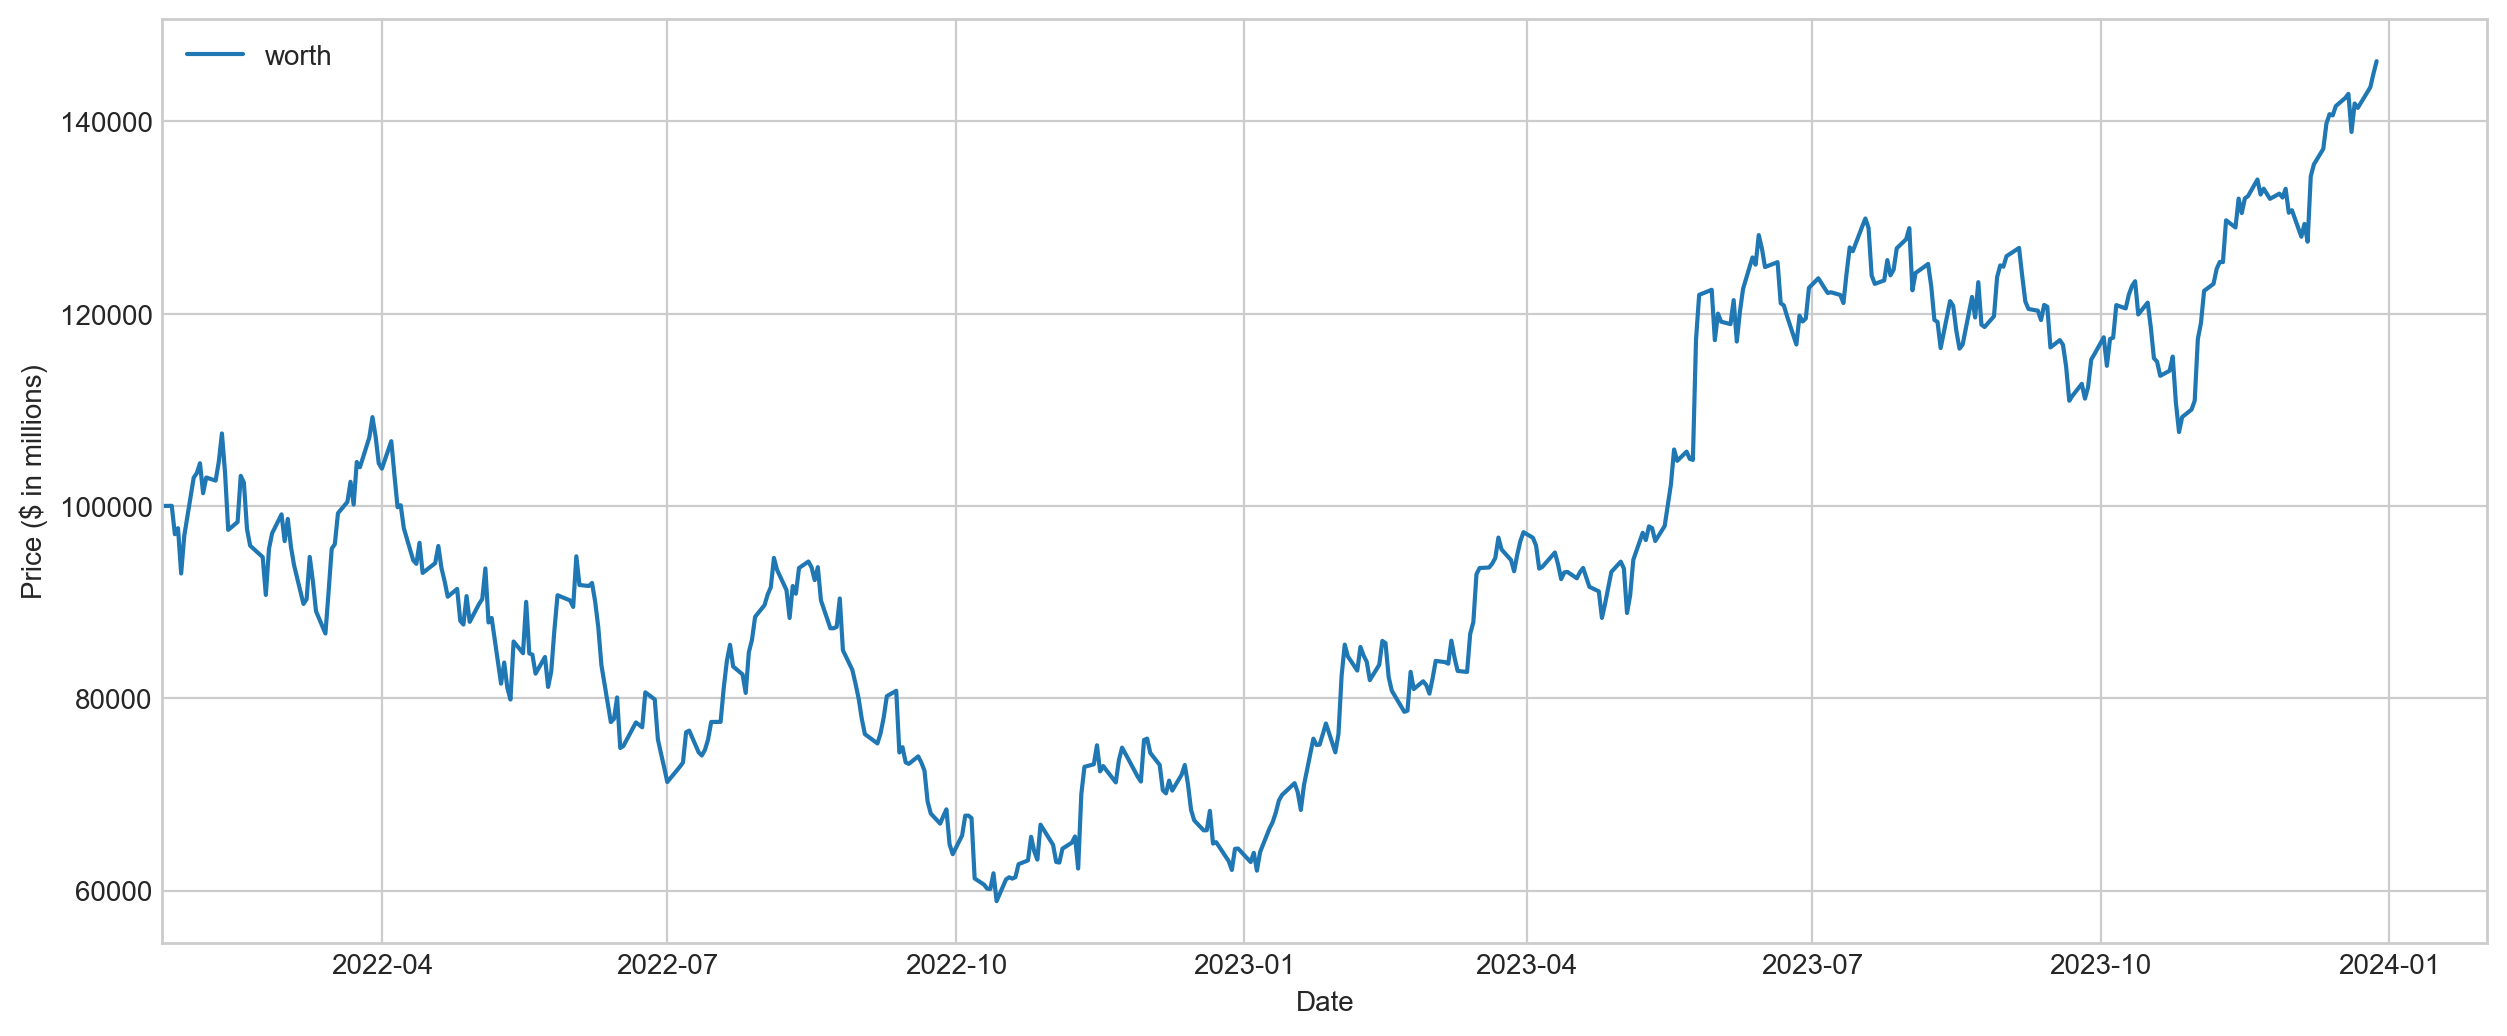

In [42]:
df_model = pd.DataFrame.from_dict(portfolio_model.worth_history, orient='index')

fig, ax = plt.subplots(figsize=(15, 6), dpi=200)

ax.plot(df_model.index, df_model['worth'], label='worth')

ax.set_xlabel('Date')
ax.set_ylabel('Price ($ in millions)')
ax.set_xlim(left=df_model.index.min())

ax.legend()
plt.show()

### Equal Weight Portfolio Without Trading

In [32]:
portfolio_without_trading = Portfolio(stock_tickers=TICKERS)
portfolio_without_trading.price_history = portfolio_without_trading.get_price_history(TEST_START_DATE, TEST_END_DATE)
portfolio_without_trading.date = portfolio_without_trading.price_history.index[0]
portfolio_without_trading.setup_equal_weight()
portfolio_without_trading.describe()

[*********************100%%**********************]  5 of 5 completed

Current positions as of 2022-01-21 00:00:00
---------------
Ticker: AAPL
Price: 162.41
Quantity: 123
Weight: 0.1997643
---------------
Ticker: ADBE
Price: 499.91
Quantity: 40
Weight: 0.199964
---------------
Ticker: AMD
Price: 118.81
Quantity: 168
Weight: 0.19960080000000002
---------------
Ticker: NVDA
Price: 23.37
Quantity: 855
Weight: 0.19981349999999998
---------------
Ticker: TSLA
Price: 314.63
Quantity: 63
Weight: 0.19821689999999997
---------------
Cash: 264.05
---------------
Portfolio worth: 100000.0


In [33]:
for sim_idx in range(1, len(portfolio_without_trading.price_history)):
    portfolio_without_trading.date = portfolio_without_trading.price_history.index[sim_idx]
    portfolio_without_trading.update_prices()

    if sim_idx == (len(portfolio_without_trading.price_history) - 1):
        portfolio_without_trading.describe()

Current positions as of 2023-12-28 00:00:00
---------------
Ticker: AAPL
Price: 193.58
Quantity: 123
Weight: 0.18151333303500825
---------------
Ticker: ADBE
Price: 595.52
Quantity: 40
Weight: 0.18159307273900013
---------------
Ticker: AMD
Price: 148.76
Quantity: 168
Weight: 0.19051904067494857
---------------
Ticker: NVDA
Price: 49.52
Quantity: 855
Weight: 0.3227674159784798
---------------
Ticker: TSLA
Price: 253.18
Quantity: 63
Weight: 0.12159420556118113
---------------
Cash: 264.05
---------------
Portfolio worth: 131176.81


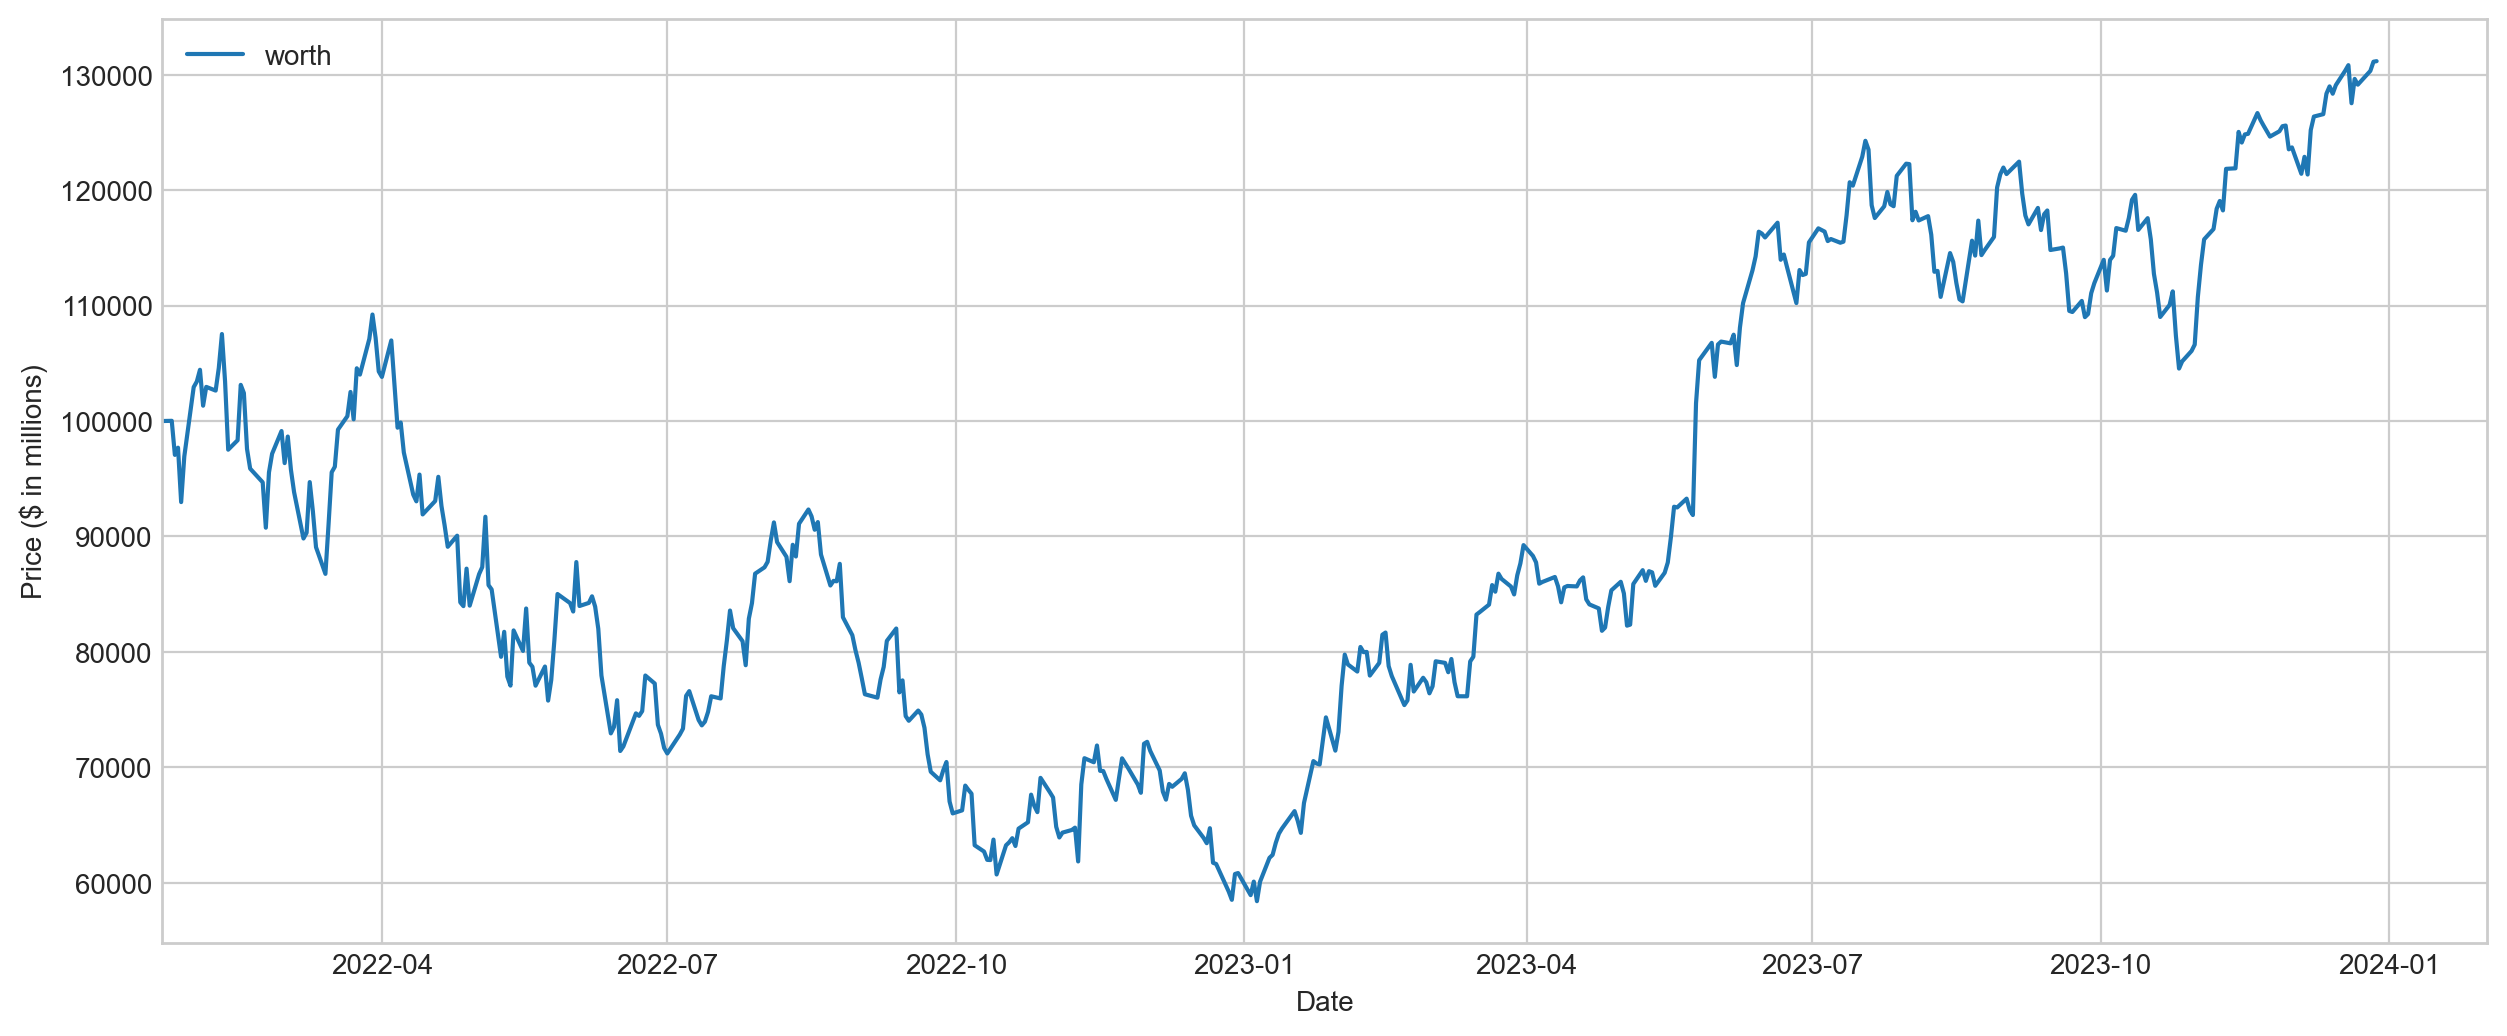

In [34]:
df_pwt = pd.DataFrame.from_dict(portfolio_without_trading.worth_history, orient='index')

fig, ax = plt.subplots(figsize=(15, 6), dpi=200)

ax.plot(df_pwt.index, df_pwt['worth'], label='worth')

ax.set_xlabel('Date')
ax.set_ylabel('Price ($ in millions)')
ax.set_xlim(left=df_pwt.index.min())

ax.legend()
plt.show()

### Best Stock Portfolio

In [35]:
portfolio_best_stock = Portfolio(stock_tickers=['NVDA'])
portfolio_best_stock.price_history = portfolio_best_stock.get_price_history(TEST_START_DATE, TEST_END_DATE)
portfolio_best_stock.date = portfolio_best_stock.price_history.index[0]
portfolio_best_stock.setup_best_stock(ticker='NVDA')
portfolio_best_stock.describe()

[*********************100%%**********************]  1 of 1 completed

Current positions as of 2022-01-21 00:00:00
---------------
Ticker: NVDA
Price: 23.37
Quantity: 4278
Weight: 0.9997686
---------------
Cash: 23.14
---------------
Portfolio worth: 100000.0


In [36]:
for sim_idx in range(1, len(portfolio_best_stock.price_history)):
    portfolio_best_stock.date = portfolio_best_stock.price_history.index[sim_idx]
    portfolio_best_stock.update_prices()

    if sim_idx == (len(portfolio_best_stock.price_history) - 1):
        portfolio_best_stock.describe()

Current positions as of 2023-12-28 00:00:00
---------------
Ticker: NVDA
Price: 49.52
Quantity: 4278
Weight: 0.9998907819287044
---------------
Cash: 23.14
---------------
Portfolio worth: 211869.7


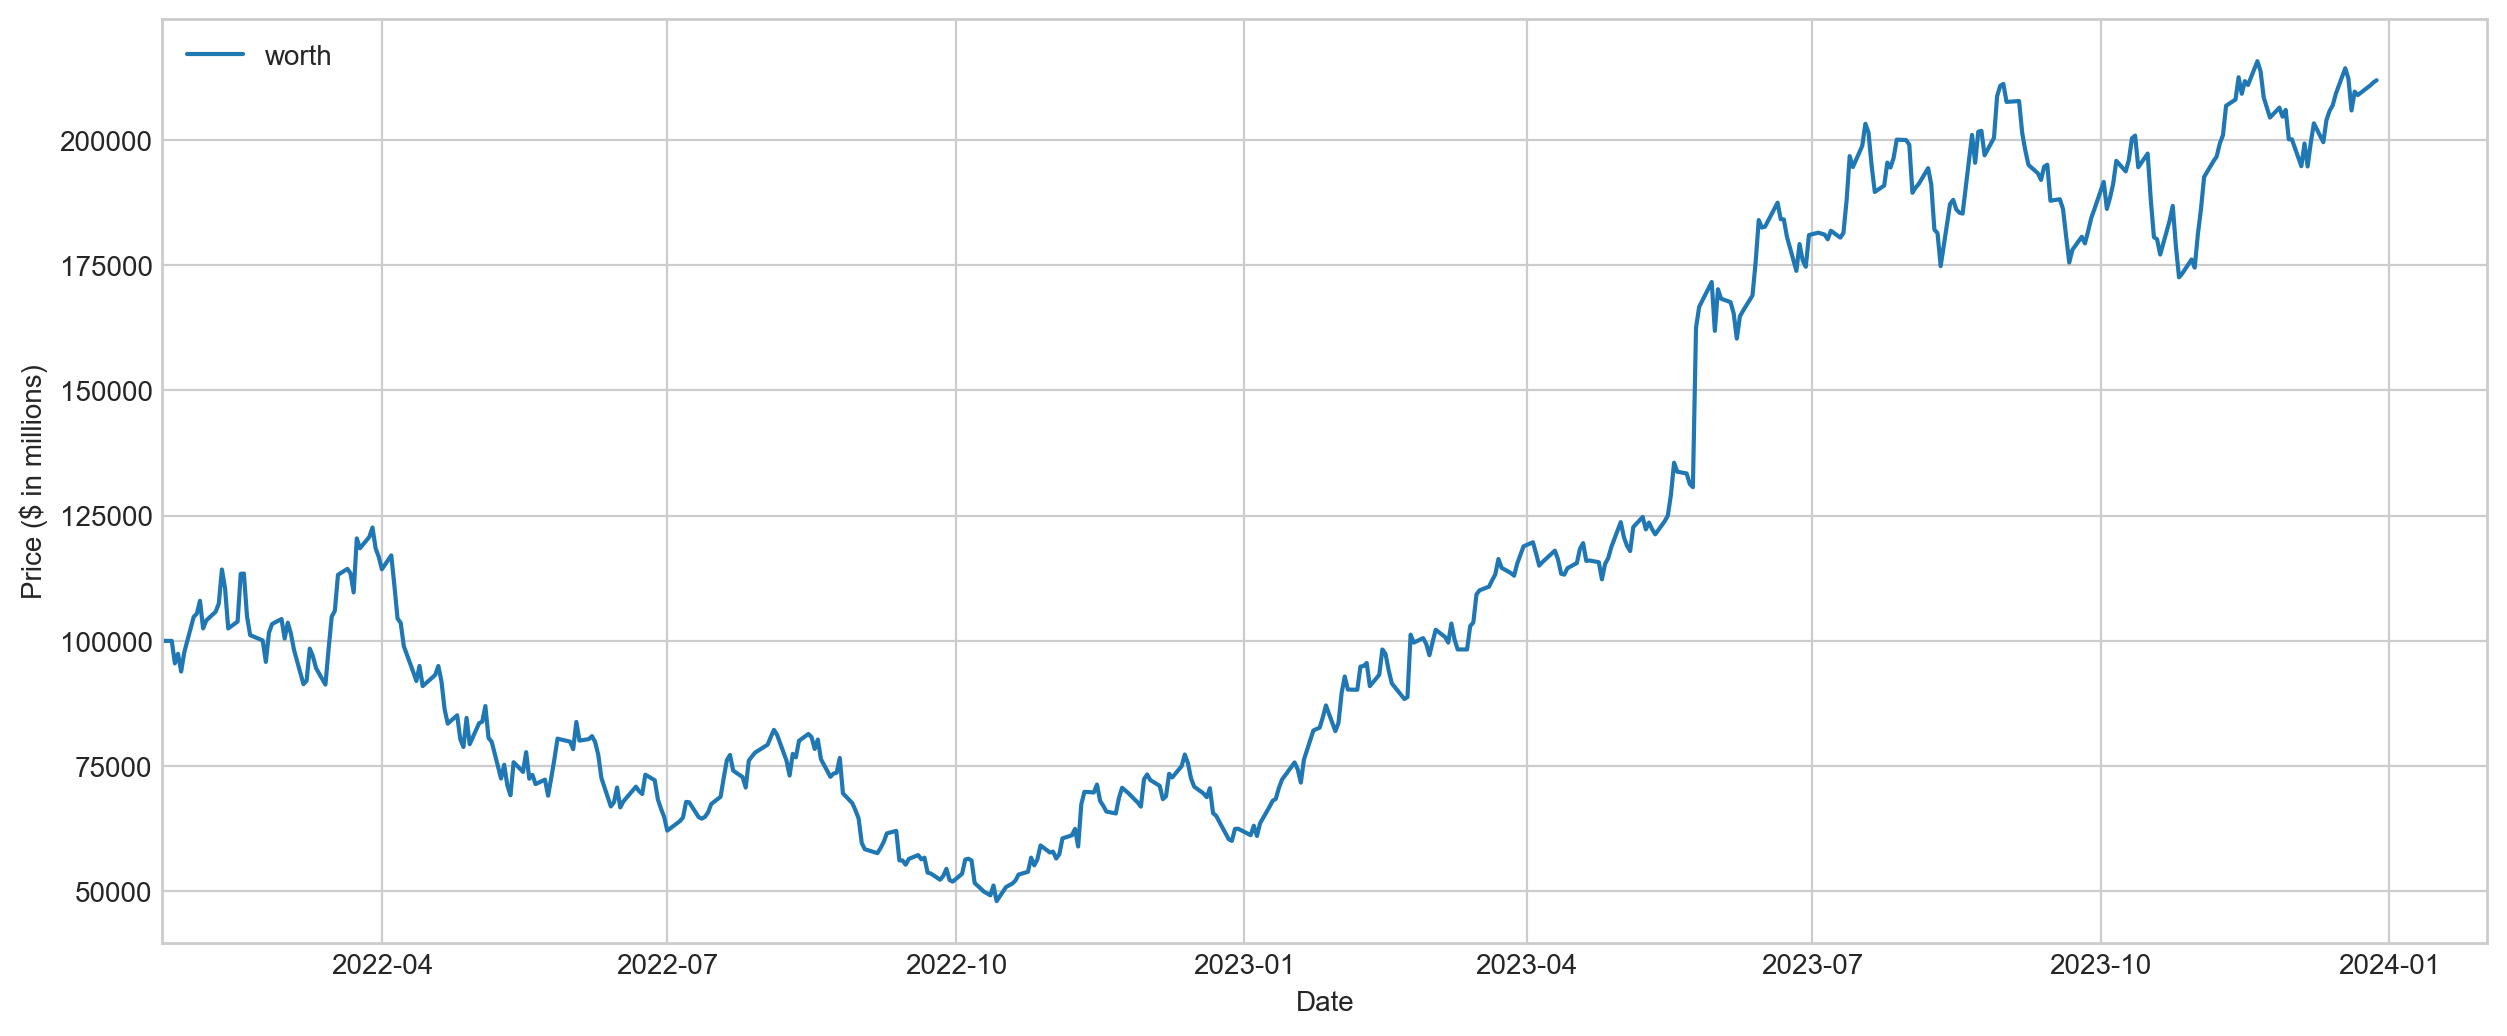

In [37]:
df_bs = pd.DataFrame.from_dict(portfolio_best_stock.worth_history, orient='index')

fig, ax = plt.subplots(figsize=(15, 6), dpi=200)

ax.plot(df_pwt.index, df_bs['worth'], label='worth')

ax.set_xlabel('Date')
ax.set_ylabel('Price ($ in millions)')
ax.set_xlim(left=df_bs.index.min())

ax.legend()
plt.show()

### Market Portfolio

In [38]:
portfolio_market = Portfolio(stock_tickers=['^GSPC'])
portfolio_market.price_history = portfolio_market.get_price_history(TEST_START_DATE, TEST_END_DATE)
portfolio_market.date = portfolio_market.price_history.index[0]
portfolio_market.setup_market('^GSPC')
portfolio_market.describe()

[*********************100%%**********************]  1 of 1 completed

Current positions as of 2022-01-21 00:00:00
---------------
Ticker: ^GSPC
Price: 4397.94
Quantity: 22
Weight: 0.9675467999999999
---------------
Cash: 3245.32
---------------
Portfolio worth: 100000.0


In [39]:
for sim_idx in range(1, len(portfolio_market.price_history)):
    portfolio_market.date = portfolio_market.price_history.index[sim_idx]
    portfolio_market.update_prices()

    if sim_idx == (len(portfolio_market.price_history) - 1):
        portfolio_market.describe()

Current positions as of 2023-12-28 00:00:00
---------------
Ticker: ^GSPC
Price: 4783.35
Quantity: 22
Weight: 0.9700834318009142
---------------
Cash: 3245.32
---------------
Portfolio worth: 108479.02


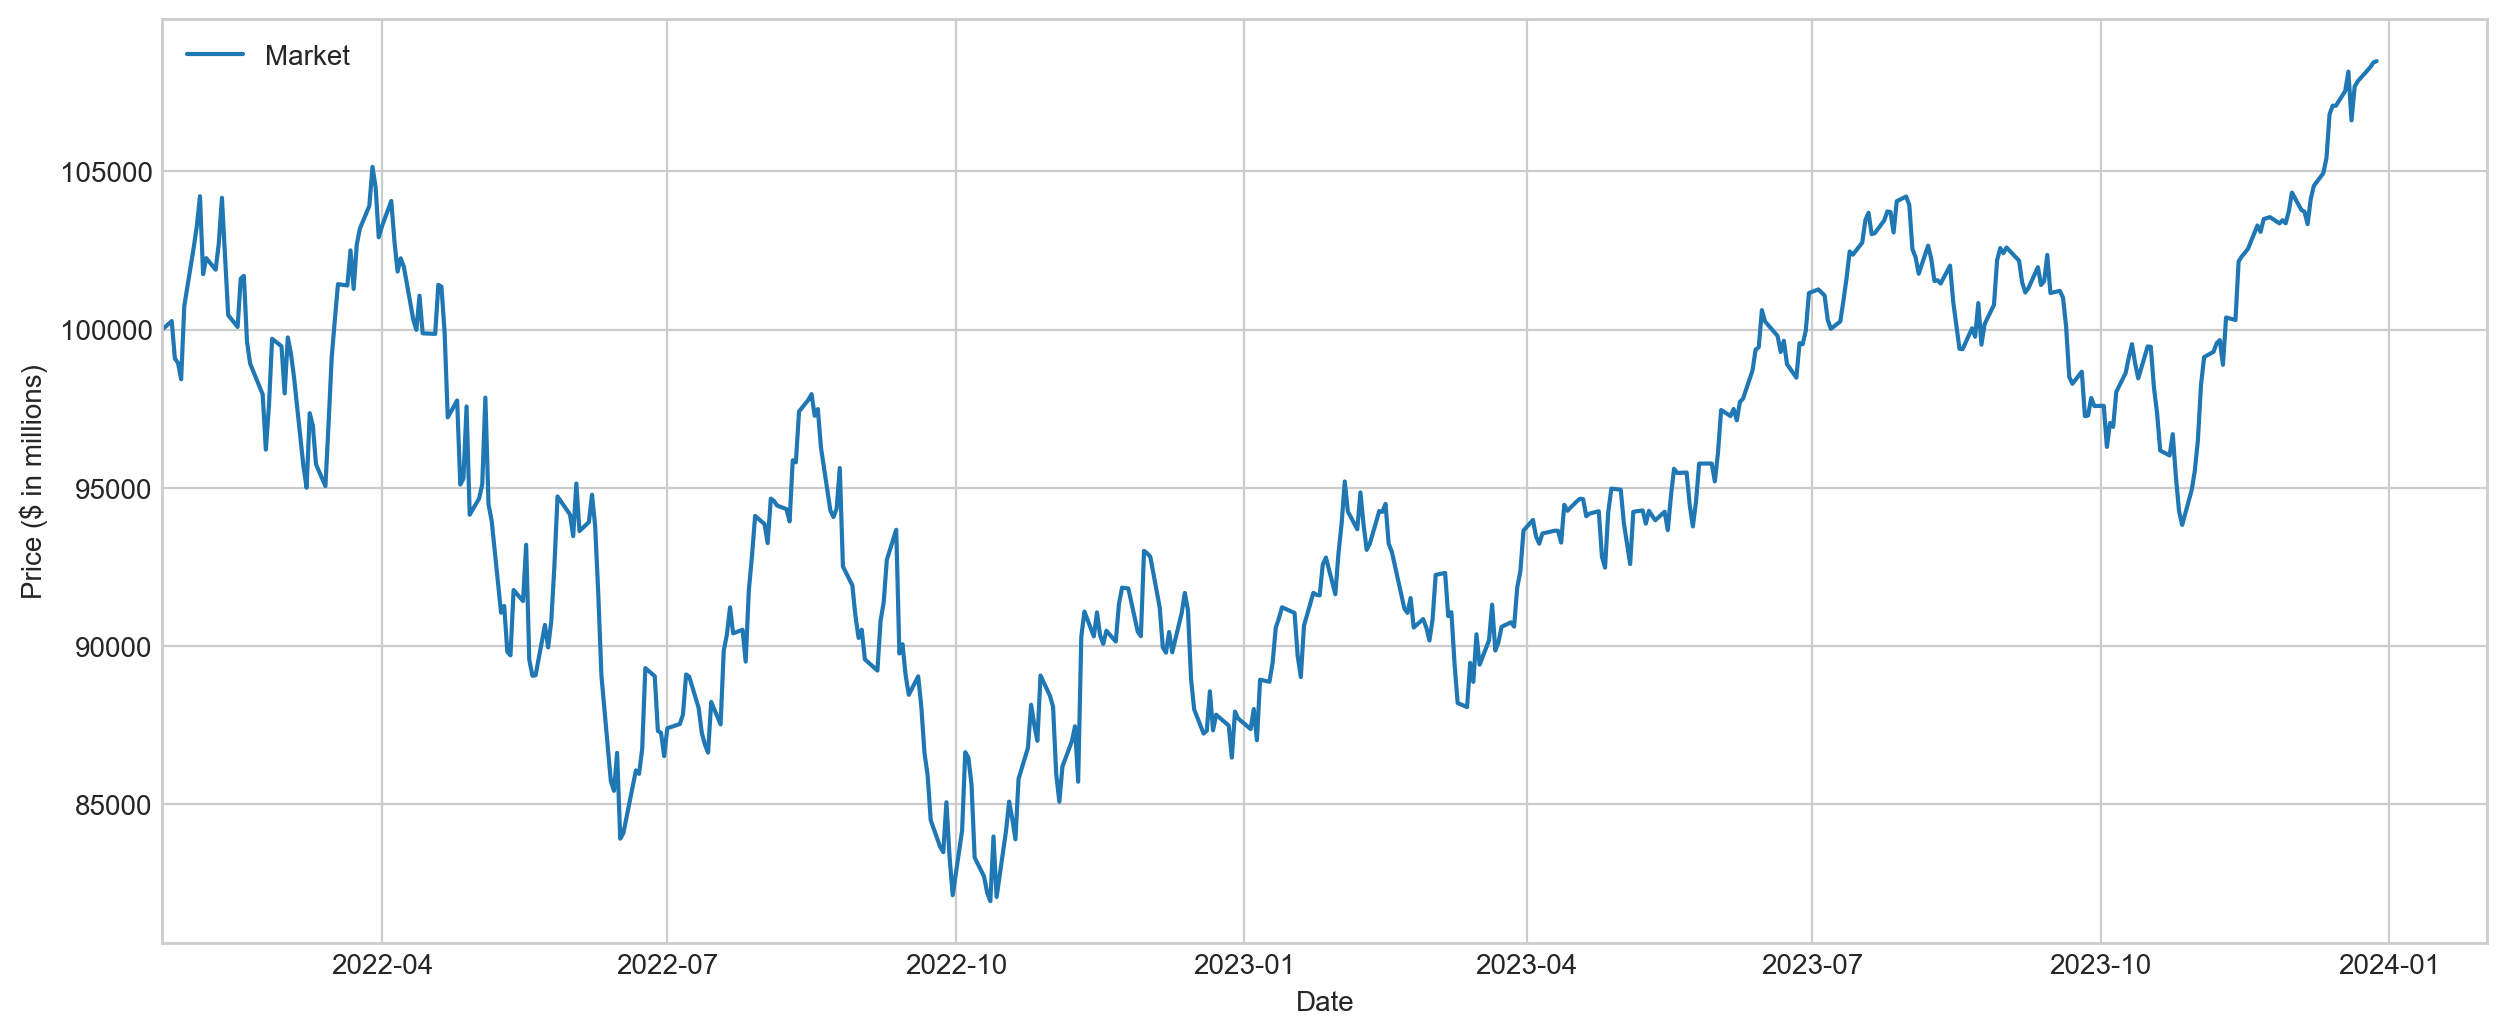

In [40]:
df_m = pd.DataFrame.from_dict(portfolio_market.worth_history, orient='index')

fig, ax = plt.subplots(figsize=(15, 6), dpi=200)

ax.plot(df_m.index, df_m['worth'], label='Market')

ax.set_xlabel('Date')
ax.set_ylabel('Price ($ in millions)')
ax.set_xlim(left=df_m.index.min())

ax.legend()
plt.show()

## Visualisation

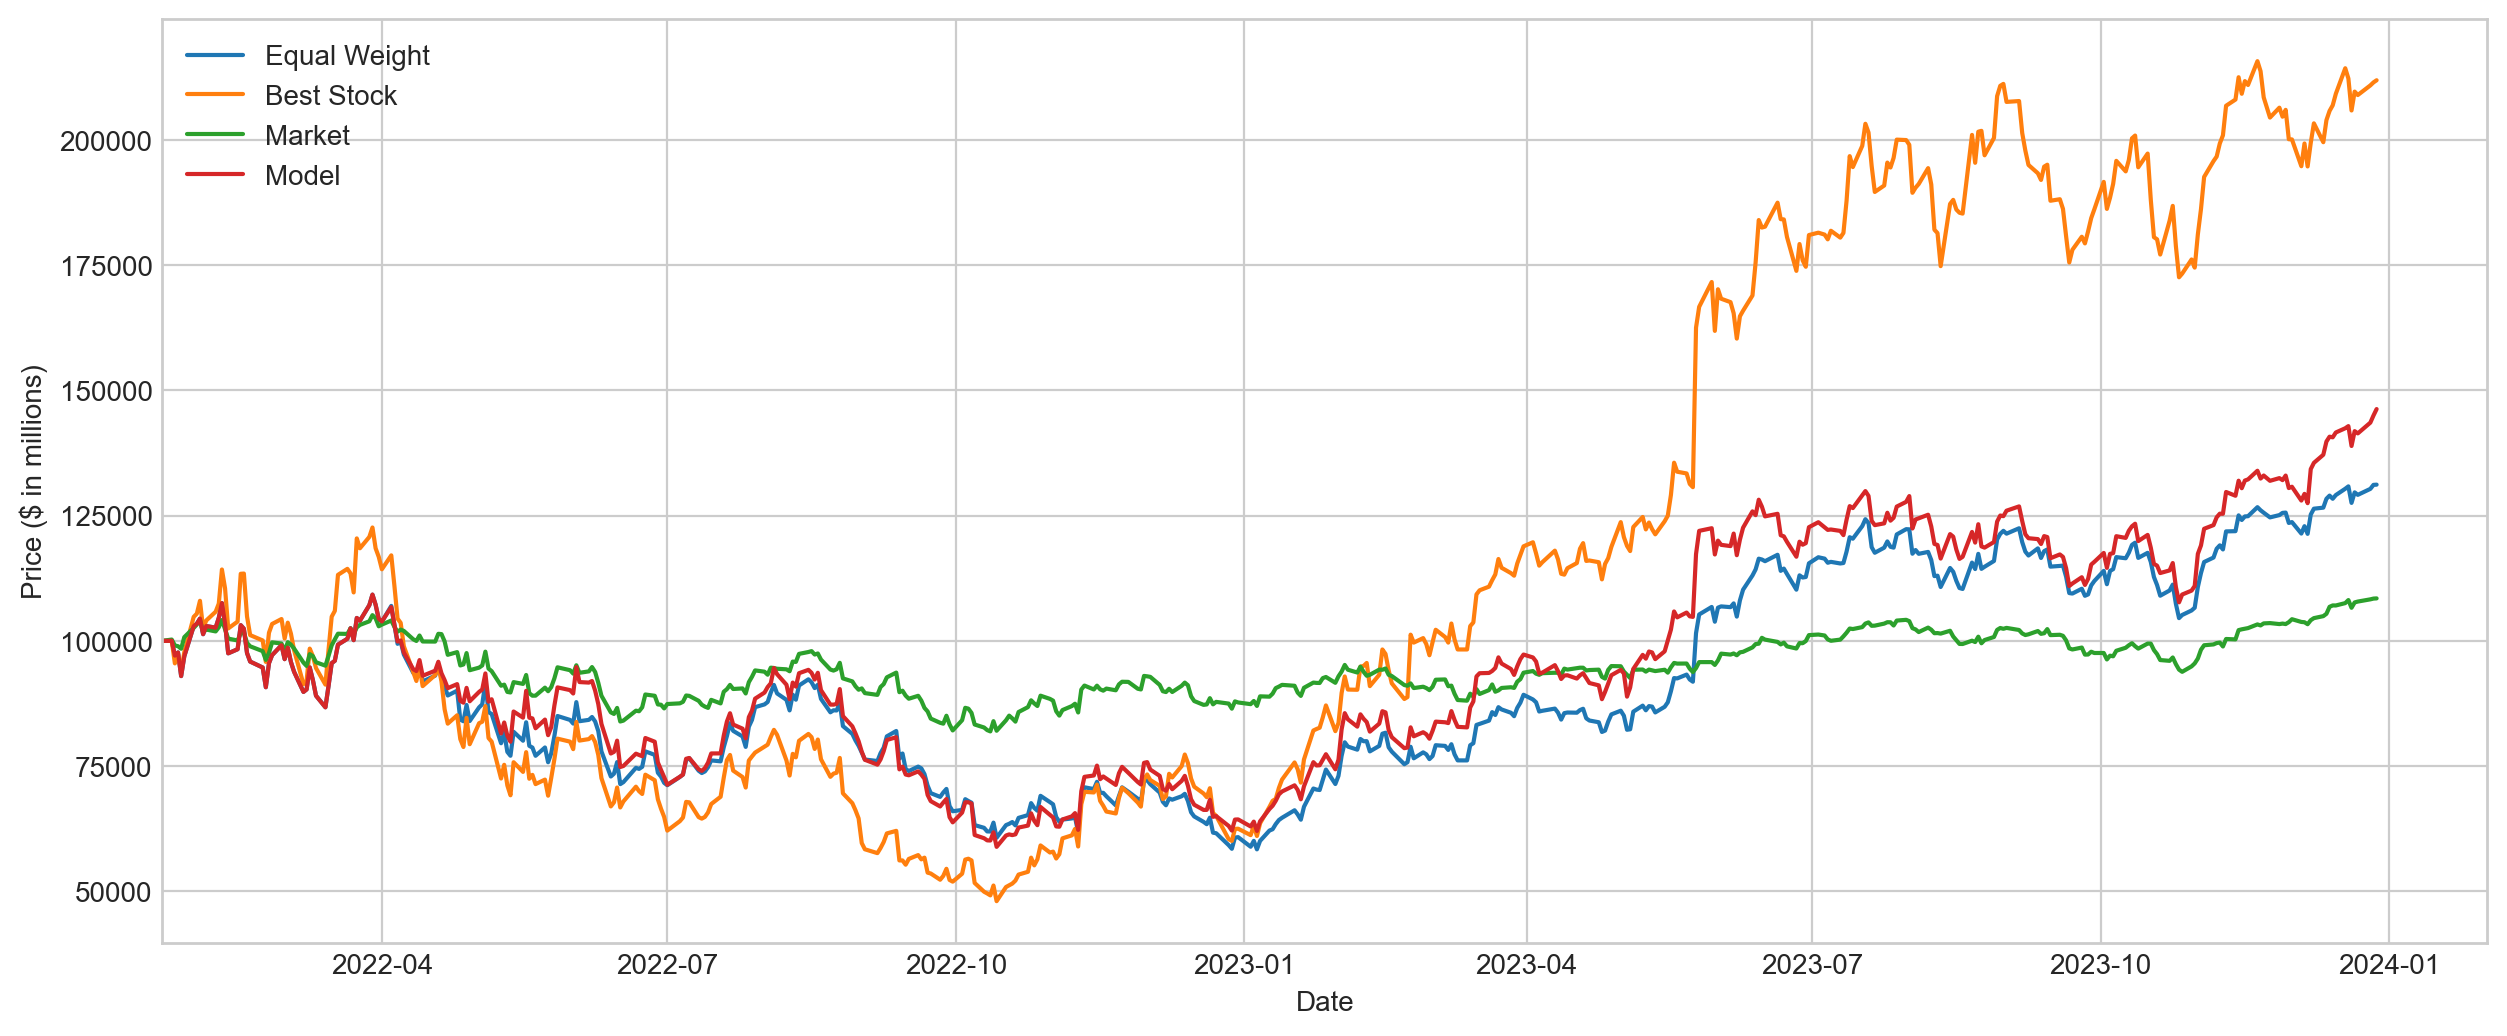

In [44]:
df_m = pd.DataFrame.from_dict(portfolio_market.worth_history, orient='index')

fig, ax = plt.subplots(figsize=(15, 6), dpi=200)

ax.plot(df_pwt.index, df_pwt['worth'], label='Equal Weight')
ax.plot(df_bs.index, df_bs['worth'], label='Best Stock')
ax.plot(df_m.index, df_m['worth'], label='Market')
ax.plot(df_model.index, df_model['worth'], label='Model')

ax.set_xlabel('Date')
ax.set_ylabel('Price ($ in millions)')
ax.set_xlim(left=df_m.index.min())

ax.legend()
plt.show()

In [51]:
print(f"Portfolio worths at the end of the period: {TEST_END_DATE}")
print("=" * 40)
print(f"Best Stock Buy-and-Hold: {df_bs.iloc[-1].values}")
print(f"Equal Weight Model Portfolio with Trading: {df_model.iloc[-1].values}")
print(f"Equal Weight Buy-and-Hold: {df_pwt.iloc[-1].values}")
print(f"Market Buy-and-Hold: {df_m.iloc[-1].values}")

Portfolio worths at the end of the period: 2023-12-29
Best Stock Buy-and-Hold: [211869.7]
Equal Weight Model Portfolio with Trading: [146258.9]
Equal Weight Buy-and-Hold: [131176.81]
Market Buy-and-Hold: [108479.02]
